# Imports & Pickles

In [0]:
#@title
from bs4 import BeautifulSoup
import types
import requests
import pymongo
import urllib
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from pymongo import MongoClient
from bson.objectid import ObjectId

In [0]:
#@title
df = pd.read_pickle('/content/drive/My Drive/project4_df.pickle')
clean_df = pd.read_pickle('/content/drive/My Drive/clean_df.pickle')
data_dtm = pd.read_pickle('/content/drive/My Drive/data_dtm.pickle')
data_stop = pd.read_pickle("/content/drive/My Drive/dtm_stop.pkl")
eda_df = pd.read_pickle("/content/drive/My Drive/eda_df.pickle")
dtm_stop = pd.read_pickle("/content/drive/My Drive/dtm_stop.pkl")
data_words = pd.read_pickle("/content/drive/My Drive/data_words.pickle")
data_unique_sort = pd.read_pickle('/content/drive/My Drive/data_unique_sort.pickle')
cv = pd.read_pickle('/content/drive/My Drive/cv_stop.pkl')

# Scraping

In [0]:
main_url = 'http://transcripts.cnn.com/TRANSCRIPTS/abpu.html'
response = requests.get(main_url)

In [0]:
page = response.text

In [0]:
soup = BeautifulSoup(page, 'html5lib')

In [0]:
episodes = []
for div in soup.find_all('div', class_='cnnSectBulletItems'):
    for link in div.find_all('a'):
        episodes.append(link.text)

In [0]:
len(episodes)

351

In [0]:
episodes[:10]

['Cologne, Germany. Aired 9-10p ET',
 'Parts Unknown: Senegal. Aired 9-10p ET',
 'Tbilisi, Georgia. Aired 9-10p ET',
 'Parts Unknown: Montana. Aired 9-10p ET',
 'The Greek Islands. Aired 9-10p ET',
 'Parts Unknown - Chicago. Aired 9-10p ET',
 'Parts Unknown: Prime Cuts Season 6. Aired 8-9p ET',
 'Parts Unknown: Manila. Aired 9-10p ET',
 'Jerusalem',
 'Anthony Bourdain, Parts Unknown: Sicily']

In [0]:
links = []
for div in soup.find_all('div', class_='cnnSectBulletItems'):
    for link in div.find_all('a'):
        ep_url = 'http://transcripts.cnn.com'+ link.get("href")
        links.append(ep_url)

In [0]:
len(links)

351

In [0]:
links[:10]

['http://transcripts.cnn.com/TRANSCRIPTS/1606/05/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/29/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/22/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/15/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/08/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/01/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1604/24/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1604/24/abpu.02.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1512/23/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1512/22/abpu.01.html']

In [0]:
episodes_and_urls = dict(zip(episodes, links))

In [0]:
episodes_and_urls

{'ANTHONY BOURDAIN - PARTS UNKNOWN - Travel to Myanmar': 'http://transcripts.cnn.com/TRANSCRIPTS/1304/20/abpu.01.html',
 'Anthony Bourdain In Koreatown': 'http://transcripts.cnn.com/TRANSCRIPTS/1312/21/abpu.01.html',
 'Anthony Bourdain Parts Unknown: Cuba; Aired September 27, 2015, 21:00 ET': 'http://transcripts.cnn.com/TRANSCRIPTS/1509/27/abpu.02.html',
 'Anthony Bourdain Parts Unknown: Myanmar': 'http://transcripts.cnn.com/TRANSCRIPTS/1312/23/abpu.01.html',
 'Anthony Bourdain Parts Unknown: Punjab': 'http://transcripts.cnn.com/TRANSCRIPTS/1404/13/abpu.02.html',
 'Anthony Bourdain Parts Unknown: South Africa': 'http://transcripts.cnn.com/TRANSCRIPTS/1310/26/abpu.02.html',
 'Anthony Bourdain Parts Unknown: Tanzania': 'http://transcripts.cnn.com/TRANSCRIPTS/1410/30/abpu.01.html',
 'Anthony Bourdain, Parts Unknown: Canada': 'http://transcripts.cnn.com/TRANSCRIPTS/1305/05/abpu.02.html',
 'Anthony Bourdain, Parts Unknown: Canada.  Aired 9:00-10:00p ET.': 'http://transcripts.cnn.com/TRANSCR

In [0]:
first_5 = {k: episodes_and_urls[k] for k in list(episodes_and_urls)[:5]}
print(first_5)

{'Cologne, Germany. Aired 9-10p ET': 'http://transcripts.cnn.com/TRANSCRIPTS/1606/05/abpu.01.html', 'Parts Unknown: Senegal. Aired 9-10p ET': 'http://transcripts.cnn.com/TRANSCRIPTS/1605/29/abpu.01.html', 'Tbilisi, Georgia. Aired 9-10p ET': 'http://transcripts.cnn.com/TRANSCRIPTS/1605/22/abpu.01.html', 'Parts Unknown: Montana. Aired 9-10p ET': 'http://transcripts.cnn.com/TRANSCRIPTS/1605/15/abpu.01.html', 'The Greek Islands. Aired 9-10p ET': 'http://transcripts.cnn.com/TRANSCRIPTS/1605/08/abpu.01.html'}


In [0]:
# Remove dupes

remove_keys = ( \
               'ANTHONY BOURDAIN - PARTS UNKNOWN - Travel to Myanmar', \
               'Anthony Bourdain, Parts Unknown: Canada.  Aired 9:00-10:00p ET.', \
               'Anthony Bourdain, Parts Unknown; Detroit', \
               'Anthony Bourdain: Parts Unknown -- Prime Cuts, Season 1', \
               'Anthony Bourdain: Parts Unknown Season 5 Prime Cuts. Aired 8-9p ET', \
               'Anthony Bourdain: Prime Cuts Season Four. Aired 8-9p ET', \
               'Anthony Bourdain Parts Unknown: Cuba; Aired September 27, 2015, 21:00 ET', \
               'Borneo. Aired 9-10p ET', \
               'Back to Beirut. Aired 9-10p ET', \
               'Budapest.  Aired 8-9p ET.', \
               'Budapest.  Aired 9:00p-10:00p ET.', \
               'Budapest. Aired 7-8p ET', \
               'Cuba. Aired 8-9p ET', \
               'Detroit', \
               'Ethiopia.  Aired 10-11p ET.', \
               'Ethiopia. Aired 8-9p ET', \
               'Glasgow, Scotland. Aired 10-11p ET', \
               'Glasgow, Scotland. Aired 8-9p ET', \
               'Hawaii.  Aired 9:00-10:00p ET.', \
               'Hawaii. Aired 8-9p ET', \
               'Jamaica.  Aired 21:00-22:00p ET.', \
               'Madagascar.  Aired 9:00-10:00p ET', \
               'Madagascar.  Aired 9:00-10:00p ET.', \
               'Madagascar. Aired 8-9p ET', \
               'Madagascar. Aired 9-10p ET', \
               'Miami.  Aired 9-10:00p ET.', \
               'Miami. Aired 11p-12a ET', \
               'Miami. Aired 8-9p ET.', \
               'New Jersey. Aired 9-10 ET', \
               'Okinawa.  Aired 10-11p ET.', \
               'Okinawa.  Aired 9-10p ET.', \
               'Parts Unknown: Mississippi Delta', \
               'Parts Unknown: Prime Cuts Season 6. Aired 8-9p ET', \
               'Parts Unknown; Detroit', \
               'Prime Cuts, Season 1', \
               'Prime Cuts: Season 3', \
               'Punjab. Aired 9-10p ET', \
               'Season 3 Choice Cuts', \
               'Season Finale, Parts Unknown, Last Bite', \
               'Season Five Prime Cuts. Aired 7-8p ET', \
               'South Korea. Aired 9-10p ET', \
               'Travel to Myanmar', \
               'Anthony Bourdain In Koreatown', \
               'Anthony Bourdain Parts Unknown: Punjab', \
               'Anthony Bourdain Parts Unknown: South Africa', \
               'Anthony Bourdain Parts Unknown: Tanzania', \
               'Anthony Bourdain, Parts Unknown: Sicily', \
               'Anthony Bourdain, Parts Unknown: Spain', \
               'Anthony Bourdain, Parts Unknown: Tokyo', \
               'Anthony Bourdain: Parts Unknown- Jerusalem', \
               'Bahia, Brazil', \
               'Myanmar', \
               'Parts Unknown: Brazil', \
               'Parts Unknown: Colombia', \
               'Parts Unknown: Iran', \
               'Parts Unknown: Las Vegas', \
               'Parts Unknown: Lyon, France', \
               'Parts Unknown: Massachusetts', \
               'Parts Unknown: Mexico', \
               'Parts Unknown: Myanmar', \
               'Parts Unknown: Peru', \
               'Parts Unknown: Russia', \
               'Parts Unknown: Tangier, Morocco', \
               'Parts Unknown: Thailand', \
               'Parts Unknown: Peru', \
               'Parts Unknown: Thailand', \
              )

In [0]:
for k in remove_keys:
    episodes_and_urls.pop(k, None)

In [0]:
episodes = [ k for k in episodes_and_urls]

In [0]:
episodes

['Cologne, Germany. Aired 9-10p ET',
 'Parts Unknown: Senegal. Aired 9-10p ET',
 'Tbilisi, Georgia. Aired 9-10p ET',
 'Parts Unknown: Montana. Aired 9-10p ET',
 'The Greek Islands. Aired 9-10p ET',
 'Parts Unknown - Chicago. Aired 9-10p ET',
 'Parts Unknown: Manila. Aired 9-10p ET',
 'Jerusalem',
 'Cuba. Aired 7-8p ET',
 'Iran',
 'Beirut.  Aired 9-10p ET',
 'Charleston. Aired 9-10p ET',
 'Turkey.  Aired 9-10p ET',
 'Borneo. Aired 8-9p ET',
 'Istanbul. Aired 9-10p ET',
 'Malaysia.  Aired 9-10p ET.',
 'Ethiopia. Aired 9-10p ET',
 'South Korea',
 'Okinawa. Aired 9-10p ET',
 'Marseille, France. Aired 9-10p ET',
 'Parts Unknown: Mississippi',
 'Mexico',
 'New Jersey. Aired 7-8p ET',
 'Hawaii. Aired 9-10p ET',
 'Budapest.  Aired 10:00p-11:00p ET.',
 'Miami',
 'Parts Unknown: New Mexico',
 'Brazil',
 'Spain',
 'Peru',
 'Madagascar.  Aired 10-11p ET.',
 'Glasgow, Scotland. Aired 9-10p ET',
 'Tokyo',
 'Vietnam',
 'Lyon, France',
 'Parts Unknown: Libya',
 'Parts Unknown: The Congo',
 'Tanzania',

In [0]:
episodes = [episodes.replace(',', '').replace('Aired 9-10p ET', '').replace('Aired 7-8p ET', '').replace('Aired 8-9p ET', '') \
             .replace('Aired 10-11p ET', '').replace('Aired 10:00p-11:00p ET', '').replace('.', '').replace(':', '').replace('Parts Unknown', '').replace('-', '') \
             .replace('Anthony Bourdain', '').replace(' ', '')
             for episodes in episodes]

In [0]:
episodes = [e.lower() for e in episodes]

In [0]:
episodes[:10]

['colognegermany',
 'senegal',
 'tbilisigeorgia',
 'montana',
 'thegreekislands',
 'chicago',
 'manila',
 'jerusalem',
 'cuba',
 'iran']

In [0]:
len(episodes)

57

In [0]:
sorted(episodes)

['beirut',
 'borneo',
 'brazil',
 'budapest',
 'canada',
 'charleston',
 'chicago',
 'colognegermany',
 'colombia',
 'copenhagen',
 'cuba',
 'detroit',
 'ethiopia',
 'exploringkoreatowninlosangeles',
 'glasgowscotland',
 'hawaii',
 'iran',
 'istanbul',
 'jamaica',
 'jerusalem',
 'lasvegas',
 'libya',
 'lyonfrance',
 'madagascar',
 'malaysia',
 'manila',
 'marseillefrance',
 'massachusetts',
 'mexico',
 'miami',
 'mississippi',
 'montana',
 'myanmar',
 'newjersey',
 'newmexico',
 'okinawa',
 'paraguay',
 'peru',
 'punjab',
 'quebec',
 'russia',
 'senegal',
 'shanghai',
 'sicily',
 'southafrica',
 'southkorea',
 'spain',
 'tangiermorocco',
 'tanzania',
 'tbilisigeorgia',
 'thailand',
 'thebronx',
 'thecongo',
 'thegreekislands',
 'tokyo',
 'turkey',
 'vietnam']

In [0]:
links = [ v for v in episodes_and_urls.values() ]

In [0]:
len(links)

57

In [0]:
links

['http://transcripts.cnn.com/TRANSCRIPTS/1606/05/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/29/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/22/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/15/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/08/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1605/01/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1604/24/abpu.02.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1411/27/abpu.07.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1510/11/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1411/02/abpu.02.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1512/10/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1511/15/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1511/12/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1511/08/abpu.01.html',
 'http://transcripts.cnn.com/TRANSCRIPTS/1511/08/abpu.02.html',
 'http://transcripts.cnn.com/TRANSCRIPTS

## Extracting and cleaning transcript HTML

In [0]:
tomato_soup = []
for link in links:
  r = requests.get(link)
  content = r.text
  soup = BeautifulSoup(content,'html5lib')
  tomato_soup.append(soup)

In [0]:
len(tomato_soup)

57

In [0]:
def replace_with_newlines(element):
    text = ''
    for elem in element.recursiveChildGenerator():
        if isinstance(elem, str):
            text += elem.strip()
        elif elem.name == 'br':
            text += '\n'
    return text

In [0]:
def get_plain_text(soup):
    plain_text = ''
    lines = soup.find("body")
    for line in lines.findAll('p')[5:]:
        line = replace_with_newlines(line)
        plain_text+=line
    return plain_text

In [0]:
cleaned_up = []
def clean(tomato_soup):
  for i in tomato_soup:
    cleaned_up.append(get_plain_text(i))

In [0]:
clean(tomato_soup)

In [0]:
len(cleaned_up)

57

In [0]:
cleaned_up

['\n(COMMERCIAL BREAK)\n\n[21:00:16] UNIDENTIFIED MALE:  (Through translator) The Ground Rules of Kolsch.  It is what it is.  It\'ll come as it comes.  It\'s always gone well.  What\'s gone is gone.  Nothing stays as it was.  Don\'t know it, don\'t need it, chuck it.  What\'re you going to do?  Do it right, but not too often.  What\'s with that?  You drinking\' one with us?\n\n(COMMERCIAL BREAK)\n\nANTHONY BOURDAIN, CNN HOST:  They say, and by "they," I mean people from around here, that Cologne is an ugly city.  This is quickly followed by the proud statement that the people are nice.  That they are welcoming, tolerant, kind, open to new things.  I never saw Cologne as ugly at all.  I always saw it as, well, charming in the least patronizing sense of the word.  I mean, this city charms you. It takes you in.  It makes you feel welcome.\n\nMaybe it was the non-douchey beer culture here that appealed.  I don\'t mean beer culture in a judgmental neck beard hovering over you waiting for yo

## Zip episode names and transcripts into a dictionary

In [0]:
ep_and_transcript = dict(zip(episodes, cleaned_up))

In [0]:
ep_and_transcript.keys()

dict_keys(['colognegermany', 'senegal', 'tbilisigeorgia', 'montana', 'thegreekislands', 'chicago', 'manila', 'jerusalem', 'cuba', 'iran', 'beirut', 'charleston', 'turkey', 'borneo', 'istanbul', 'malaysia', 'ethiopia', 'southkorea', 'okinawa', 'marseillefrance', 'mississippi', 'mexico', 'newjersey', 'hawaii', 'budapest', 'miami', 'newmexico', 'brazil', 'spain', 'peru', 'madagascar', 'glasgowscotland', 'tokyo', 'vietnam', 'lyonfrance', 'libya', 'thecongo', 'tanzania', 'copenhagen', 'paraguay', 'colombia', 'thebronx', 'sicily', 'thailand', 'quebec', 'jamaica', 'massachusetts', 'shanghai', 'punjab', 'detroit', 'russia', 'lasvegas', 'myanmar', 'southafrica', 'exploringkoreatowninlosangeles', 'tangiermorocco', 'canada'])

In [0]:
# first_5 = {k: ep_and_transcript[k] for k in sorted(ep_and_transcript.keys())[:5]}
# print(first_5)

In [0]:
first_5 = {k: ep_and_transcript[k] for k in list(ep_and_transcript)[:5]}
print(first_5)

{'colognegermany': '\n(COMMERCIAL BREAK)\n\n[21:00:16] UNIDENTIFIED MALE:  (Through translator) The Ground Rules of Kolsch.  It is what it is.  It\'ll come as it comes.  It\'s always gone well.  What\'s gone is gone.  Nothing stays as it was.  Don\'t know it, don\'t need it, chuck it.  What\'re you going to do?  Do it right, but not too often.  What\'s with that?  You drinking\' one with us?\n\n(COMMERCIAL BREAK)\n\nANTHONY BOURDAIN, CNN HOST:  They say, and by "they," I mean people from around here, that Cologne is an ugly city.  This is quickly followed by the proud statement that the people are nice.  That they are welcoming, tolerant, kind, open to new things.  I never saw Cologne as ugly at all.  I always saw it as, well, charming in the least patronizing sense of the word.  I mean, this city charms you. It takes you in.  It makes you feel welcome.\n\nMaybe it was the non-douchey beer culture here that appealed.  I don\'t mean beer culture in a judgmental neck beard hovering over 

# MongoDB


In [0]:
config = {
    'host': '3.17.64.137:27017',
    'username': 'root',
    'password': 'password'
}

client = MongoClient(**config)

db = client.project4

In [0]:
# for k, v in ep_and_transcript.items():
#   db.bourdain.insert({"episode":k, "transcript":v})

In [0]:
# list(db.bourdain.find({}))

In [0]:
# db.bourdain.delete_one({'_id': ObjectId('5e4ccb93d9726b589999ed45')})

In [0]:
# db.bourdain.drop()

In [0]:
# data = list(db.bourdain.find({}, {'episode': 1, 'transcript': 1, '_id': 0} ))

## Mongo to Pandas DataFrame

In [0]:
pd.set_option('max_colwidth',100)

In [0]:
# df = pd.DataFrame(list(data))
# df = df.set_index('episode')
# df = df.sort_index()

In [0]:
# df['episode_num'] = np.arange(len(df))

In [0]:
# cols = df.columns.to_list()
# cols.insert(0, cols.pop(cols.index('episode_num')))
# df = df.reindex(columns = cols)

In [0]:
df.head()

,transcript
episode,
beirut,"\nANTHONY BOURDAIN, CNN HOST: There's no place else even remotely like it. Everything great an..."
borneo,"\n(COMMERCIAL BREAK)\n\n[20:00:26] ANTHONY BOURDAIN, CNN ANCHOR: When I first went up this rive..."
brazil,"\nANTHONY BOURDAIN, CNN HOST: In Bahia, you find yourself in the heart of the heart of Brazil, w..."
budapest,\n[22:00:11] UNIDENTIFIED MALE: I don't even think about death.\n\nBut shooting actually those ...
canada,"\nANTHONY BOURDAIN, HOST (voice-over): It takes a special breed to live in a province like Queb..."


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# df.to_pickle('/content/drive/My Drive/project4_df.pickle')

In [0]:
df.head()

,transcript
episode,
beirut,"\nANTHONY BOURDAIN, CNN HOST: There's no place else even remotely like it. Everything great an..."
borneo,"\n(COMMERCIAL BREAK)\n\n[20:00:26] ANTHONY BOURDAIN, CNN ANCHOR: When I first went up this rive..."
brazil,"\nANTHONY BOURDAIN, CNN HOST: In Bahia, you find yourself in the heart of the heart of Brazil, w..."
budapest,\n[22:00:11] UNIDENTIFIED MALE: I don't even think about death.\n\nBut shooting actually those ...
canada,"\nANTHONY BOURDAIN, HOST (voice-over): It takes a special breed to live in a province like Queb..."


In [0]:
# test_df = df

In [0]:
# test_df.loc[0, 'transcript']

# Text Pre-processing

In [0]:
import re
import string

In [0]:
def mr_clean(text):
    text = re.sub('([A-Z][A-Z]\w*)', '', text)
    return text

mister = lambda x: mr_clean(x)

In [0]:
def mrs_clean(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\(.*?\)', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[ ]{2,}', ' ' , text)
    return text

missus = lambda x: mrs_clean(x)

In [0]:
clean_df = df

In [0]:
clean_df['transcript'] = clean_df['transcript'].apply(mister)

In [0]:
clean_df['transcript'] = clean_df['transcript'].apply(missus)

In [0]:
# clean_df = pd.DataFrame(df.transcript.apply(mister))

In [0]:
# clean_df = pd.DataFrame(clean_df.transcript.apply(missus))

In [0]:
clean_df['episode'] = clean_df.index

In [0]:
cols = clean_df.columns.to_list()
cols.insert(0, cols.pop(cols.index('episode')))
clean_df = clean_df.reindex(columns = cols)

In [0]:
clean_df = clean_df.transpose()

In [0]:
clean_df = clean_df.rename(columns={'exploringkoreatowninlosangeles':'ktownla', \
'colognegermany':'cologne', \
'glasgowscotland':'glasgow', \
'marseillefrance':'marseille', \
'tangiermorocco':'tangier', \
'tbilisigeorgia':'tbilisi', \
'thegreekislands':'greekislands', \
'lyonfrance':'lyon'})

In [0]:
clean_df = clean_df.transpose()

In [0]:
clean_df['episode'] = clean_df.index

In [0]:
clean_df.head()

,episode,transcript
episode,,
beirut,beirut,theres no place else even remotely like it everything great and all the worlds ills all in one ...
borneo,borneo,when i first went up this river i was sick with love the bad kind the fist around your heart ki...
brazil,brazil,in bahia you find yourself in the heart of the heart of brazil where the magic comes from if yo...
budapest,budapest,i dont even think about deathbut shooting actually those russian tanks you know going through t...
canada,canada,it takes a special breed to live in a province like quebec it gets cold in winter and winters a...


## Stems and Lems


In [0]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
port = PorterStemmer()
wnl = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
clean_df['tokenized'] = clean_df['transcript'].apply(word_tokenize)

In [0]:
clean_df['stemmed'] = clean_df['tokenized'].apply(lambda x: [port.stem(y) for y in x])

In [0]:
clean_df['lemmed'] = clean_df['tokenized'].apply(lambda x: [wnl.lemmatize(y) for y in x])

In [0]:
clean_df['stemmed'] = clean_df['stemmed'].apply(' '.join)

In [0]:
clean_df['lemmed'] = clean_df['lemmed'].apply(' '.join)

In [0]:
cols = clean_df.columns.to_list()
cols.insert(2, cols.pop(cols.index('tokenized')))
clean_df = clean_df.reindex(columns = cols)

In [0]:
df_stemmed = clean_df[['episode', 'stemmed']]

In [0]:
df_lemmed = clean_df[['episode', 'lemmed']]

In [0]:
clean_df.head()

,episode,transcript,tokenized,stemmed,lemmed
episode,,,,,
beirut,beirut,theres no place else even remotely like it everything great and all the worlds ills all in one ...,"[theres, no, place, else, even, remotely, like, it, everything, great, and, all, the, worlds, il...",there no place els even remot like it everyth great and all the world ill all in one gloriou mes...,there no place else even remotely like it everything great and all the world ill all in one glor...
borneo,borneo,when i first went up this river i was sick with love the bad kind the fist around your heart ki...,"[when, i, first, went, up, this, river, i, was, sick, with, love, the, bad, kind, the, fist, aro...",when i first went up thi river i wa sick with love the bad kind the fist around your heart kindi...,when i first went up this river i wa sick with love the bad kind the fist around your heart kind...
brazil,brazil,in bahia you find yourself in the heart of the heart of brazil where the magic comes from if yo...,"[in, bahia, you, find, yourself, in, the, heart, of, the, heart, of, brazil, where, the, magic, ...",in bahia you find yourself in the heart of the heart of brazil where the magic come from if you ...,in bahia you find yourself in the heart of the heart of brazil where the magic come from if you ...
budapest,budapest,i dont even think about deathbut shooting actually those russian tanks you know going through t...,"[i, dont, even, think, about, deathbut, shooting, actually, those, russian, tanks, you, know, go...",i dont even think about deathbut shoot actual those russian tank you know go through there and s...,i dont even think about deathbut shooting actually those russian tank you know going through the...
canada,canada,it takes a special breed to live in a province like quebec it gets cold in winter and winters a...,"[it, takes, a, special, breed, to, live, in, a, province, like, quebec, it, gets, cold, in, wint...",it take a special breed to live in a provinc like quebec it get cold in winter and winter are lo...,it take a special breed to live in a province like quebec it get cold in winter and winter are l...


In [0]:
# clean_df.to_pickle('/content/drive/My Drive/clean_df.pickle')

## Document Term Matrix (Default stop words)
Raw - 18379 columns   
Stemmed - 13410 columns   
Lemmed - 16352 columns

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# cv = CountVectorizer(stop_words='english')
cv = TfidfVectorizer(stop_words='english')
data_cv = cv.fit_transform(clean_df.lemmed)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = clean_df.index

In [0]:
# data_dtm.to_pickle('/content/drive/My Drive/data_dtm.pickle')

In [0]:
data_dtm.head()

,aa,aaron,ababa,abad,abaha,abalone,abandon,abandoned,abandoning,abbott,abdelileh,abdoulaye,abduct,abduction,abdul,abed,abedelmajid,abeid,abeka,abel,abetting,abide,abides,abigail,ability,able,aboard,abouti,aboutim,aboutthe,aboveboard,abrahamthe,abroad,abroadwhat,abru,abrupt,absalom,absarika,absolute,absolutefor,...,zamirnow,zaneb,zanzibar,zanzibari,zanzibaris,zapotec,zapotecan,zarni,zayas,zeal,zealand,zeb,zebeck,zebra,zebu,zero,zeta,zeus,zhejiang,zhou,zhu,zia,zimmer,zing,zionist,zip,ziran,zocalo,zombie,zone,zoneits,zoo,zooamichai,zoowhat,zsigmond,zsigmonds,zucchini,zui,zulu,zurkowski
episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
beirut,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013561,0.0,0.0,0.0,0.0,0.0,0.000000,0.010198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017847,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
borneo,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.017299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009451,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
budapest,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014158,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.037265,0.018633,0.0,0.0,0.0,0.0
canada,0.0,0.0,0.0,0.0,0.0,0.0,0.013922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.016874,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.010019,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


## EDA

In [0]:
eda_df = data_dtm

In [0]:
eda_df = eda_df.transpose()

In [0]:
eda_df

episode,beirut,borneo,brazil,budapest,canada,charleston,chicago,cologne,colombia,copenhagen,cuba,detroit,ethiopia,ktownla,glasgow,hawaii,iran,istanbul,jamaica,jerusalem,lasvegas,libya,lyon,madagascar,malaysia,manila,marseille,massachusetts,mexico,miami,mississippi,montana,myanmar,newjersey,newmexico,okinawa,paraguay,peru,punjab,quebec,russia,senegal,shanghai,sicily,southafrica,southkorea,spain,tangier,tanzania,tbilisi,thailand,thebronx,thecongo,greekislands,tokyo,turkey,vietnam
aa,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.022247,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
aaron,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024488,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019741,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
ababa,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.055473,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
abad,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.018668,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
abaha,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02362,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zsigmonds,0.0,0.0,0.0,0.018633,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
zucchini,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.032197,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.015324,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.015968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
zui,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.023306
zulu,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010822,0.0,0.0,0.0,0.0,0.000000


In [0]:
# Find the top n words
top_dict = {}
for c in eda_df.columns:
    top = eda_df[c].sort_values(ascending=False).head(50)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'beirut': [('beirut', 0.5889567232773012),
  ('syria', 0.22909850522669908),
  ('lebanon', 0.22521889076096274),
  ('yeah', 0.20481346582529936),
  ('hezbollah', 0.1963189077591004),
  ('lebanese', 0.17809241927355463),
  ('syrian', 0.17809241927355463),
  ('like', 0.10625030392095511),
  ('wa', 0.10625030392095511),
  ('people', 0.0939906534685372),
  ('dont', 0.08882900437052653),
  ('place', 0.07764445286531335),
  ('know', 0.07355790271450738),
  ('civil', 0.07309207201289725),
  ('shiite', 0.07138869373058197),
  ('christian', 0.0667881960935577),
  ('ha', 0.06538480241289545),
  ('yes', 0.06538480241289545),
  ('time', 0.06538480241289545),
  ('war', 0.06515912708172171),
  ('israel', 0.06476087973583805),
  ('palestinian', 0.06476087973583805),
  ('really', 0.061298252262089487),
  ('radio', 0.060058370869590066),
  ('neighborhood', 0.05424472379952903),
  ('ramsey', 0.053541520297936476),
  ('sunni', 0.053541520297936476),
  ('shia', 0.053541520297936476),
  ('world', 0.053125

In [0]:
# Print the top 15 words
for episode, top_words in top_dict.items():
    print(episode)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

beirut
beirut, syria, lebanon, yeah, hezbollah, lebanese, syrian, like, wa, people, dont, place, know, civil
---
borneo
yeah, longhouse, gawai, langkau, like, wa, iban, tattoo, promise, right, karaoke, jungle, time, know
---
brazil
brazil, salvador, capoeira, caipirinha, like, yeah, brazilian, good, african, know, pelourinho, bahia, na, people
---
budapest
budapest, hungary, hungarian, wa, butcher, gypsy, vilmos, yeah, film, good, time, like, know, tank
---
canada
quebec, canadian, maple, like, fred, quebecois, beaver, yes, french, truffle, know, montreal, ice, canada
---
charleston
charleston, waffle, know, southern, cooking, wa, umami, gnat, ham, really, like, yeah, riverdogs, sand
---
chicago
chicago, cub, wa, know, like, fan, just, ale, roger, yeah, got, people, sox, mean
---
cologne
cologne, german, turkish, kolsch, carnival, refugee, like, yeah, germany, wa, beer, dont, ugly, know
---
colombia
colombia, yes, bogota, good, drug, guajira, tejo, cali, like, tomas, people, wa, wayuu,

In [0]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Pull out the top words for each episode
words = []
for episode in eda_df.columns:
    top = [word for (word, count) in top_dict[episode]]
    for t in top:
        words.append(t)
        
words

['beirut',
 'syria',
 'lebanon',
 'yeah',
 'hezbollah',
 'lebanese',
 'syrian',
 'like',
 'wa',
 'people',
 'dont',
 'place',
 'know',
 'civil',
 'shiite',
 'christian',
 'ha',
 'yes',
 'time',
 'war',
 'israel',
 'palestinian',
 'really',
 'radio',
 'neighborhood',
 'ramsey',
 'sunni',
 'shia',
 'world',
 'army',
 'year',
 'bomb',
 'damascus',
 'thats',
 'im',
 'camp',
 'lit',
 'right',
 'come',
 'let',
 'arrested',
 'neighbor',
 'beard',
 'refugee',
 'border',
 'religious',
 'million',
 'just',
 'think',
 'thing',
 'yeah',
 'longhouse',
 'gawai',
 'langkau',
 'like',
 'wa',
 'iban',
 'tattoo',
 'promise',
 'right',
 'karaoke',
 'jungle',
 'time',
 'know',
 'kuching',
 'lumpur',
 'sarawak',
 'im',
 'year',
 'malay',
 'river',
 'village',
 'going',
 'upriver',
 'chow',
 'previous',
 'yes',
 'life',
 'borneo',
 'kuala',
 'elder',
 'lot',
 'dont',
 'chocolate',
 'changed',
 'come',
 'wake',
 'noodle',
 'skull',
 'delicious',
 'harvest',
 'good',
 'drinking',
 'oh',
 'id',
 'ha',
 'just',

In [0]:
# Identify the most common words along with how many episodes they occur in
Counter(words).most_common()

[('like', 57),
 ('wa', 56),
 ('right', 53),
 ('know', 52),
 ('thats', 49),
 ('people', 47),
 ('yes', 47),
 ('good', 43),
 ('just', 41),
 ('thing', 38),
 ('im', 36),
 ('dont', 35),
 ('time', 32),
 ('going', 32),
 ('really', 31),
 ('come', 29),
 ('think', 27),
 ('year', 25),
 ('yeah', 23),
 ('place', 23),
 ('ha', 20),
 ('look', 18),
 ('lot', 16),
 ('food', 15),
 ('oh', 14),
 ('mean', 14),
 ('youre', 13),
 ('want', 13),
 ('make', 12),
 ('way', 12),
 ('city', 11),
 ('got', 11),
 ('say', 11),
 ('country', 9),
 ('day', 8),
 ('world', 7),
 ('wine', 7),
 ('theyre', 7),
 ('war', 6),
 ('river', 6),
 ('music', 6),
 ('great', 6),
 ('revolution', 6),
 ('french', 6),
 ('house', 6),
 ('town', 6),
 ('eat', 6),
 ('village', 5),
 ('life', 5),
 ('noodle', 5),
 ('drinking', 5),
 ('beautiful', 5),
 ('guy', 5),
 ('little', 5),
 ('government', 5),
 ('park', 5),
 ('culture', 5),
 ('new', 5),
 ('rice', 5),
 ('fish', 5),
 ('jungle', 4),
 ('delicious', 4),
 ('african', 4),
 ('man', 4),
 ('truffle', 4),
 ('sauce'

In [0]:
# If more than 10 episodes have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > 10]
print(add_stop_words, '\n', 'Number of words:', len(add_stop_words))

['like', 'wa', 'right', 'know', 'thats', 'people', 'yes', 'good', 'just', 'thing', 'im', 'dont', 'time', 'going', 'really', 'come', 'think', 'year', 'yeah', 'place', 'ha', 'look', 'lot', 'food', 'oh', 'mean', 'youre', 'want', 'make', 'way', 'city', 'got', 'say'] 
 Number of words: 33


In [0]:
# additional_stop_words = ['hungary', 'canadian', 'got', 'cuban', 'youre', 'iranian', 'want', 'filipino', 'new', 'moroccan', 'vietnam', 'yeah', 'look', 'thing', 'beirut', 'chicago', 'cologne', 'colombia', 'cuba', 'detroit', 'ethiopia', 'glasgow', 'iran', \
#                       'iranian', 'istanbul', 'jamaica', 'vegas', 'libya', 'lyon', 'madagascar', 'phillipine', 'marseille', 'mexico', 'miami', \
#                       'mississippi', 'montana', 'jersey', 'okinawa', 'paraguay', 'india', 'russia', 'senegal', 'china', 'sicily', 'korean', 'tangier', \
#                       'georgia', 'thailand', 'bronx', 'congo', 'greek', 'turkey']

# additional words added from first run of LDA models
# additional_stop_words = ['hungary', 'canadian', 'got', 'cuban', 'youre', 'iranian', 'want', 'filipino', 'new', 'moroccan', 'vietnam', 'yeah', 'look', 'thing', 'beirut', 'chicago', 'cologne', 'colombia', 'cuba', 'detroit', 'ethiopia', 'glasgow', 'iran', \
#                       'iranian', 'istanbul', 'jamaica', 'vegas', 'libya', 'lyon', 'madagascar', 'phillipine', 'marseille', 'mexico', 'miami', \
#                       'mississippi', 'montana', 'jersey', 'okinawa', 'paraguay', 'india', 'russia', 'senegal', 'china', 'sicily', 'korean', 'tangier', \
#                       'georgia', 'thailand', 'bronx', 'congo', 'greek', 'turkey', 'french', 'house', 'real', 'south', 'town', 'city', 'hes', 'guy', 'hawaiian', 'times', 'whats', \
#                       'local', 'special', 'village', 'school', 'chinese', 'japanese', 'sicilian', 'shanghai', 'money', 'black', 'white', 'theyre', 'wow' ]

# additional words added from run of LSA NMF
# additional_stop_words = ['hungary', 'canadian', 'got', 'cuban', 'youre', 'iranian', 'want', 'filipino', 'new', 'moroccan', 'vietnam',\
#                          'yeah', 'look', 'thing', 'beirut', 'chicago', 'cologne', 'colombia', 'cuba', 'detroit', 'ethiopia', 'glasgow', 'iran', 'iranian',\
#                          'istanbul', 'jamaica', 'vegas', 'libya', 'lyon', 'madagascar', 'phillipine', 'marseille', 'mexico', 'miami', 'mississippi', 'montana',\
#                          'jersey', 'okinawa', 'paraguay', 'india', 'russia', 'senegal', 'china', 'sicily', 'korean', 'tangier', 'georgia', 'thailand', 'bronx', 'congo', \
#                          'greek', 'turkey', 'french', 'house', 'real', 'south', 'town', 'city', 'hes', 'guy', 'hawaiian', 'times', 'whats', 'local', 'special', 'village',\
#                          'school', 'chinese', 'japanese', 'sicilian', 'shanghai', 'money', 'black', 'white', 'theyre', 'wow', 'music', 'culture', 'dish', 'quebecois', 'quebec',\
#                          'tradition', 'political', 'party', 'government', 'power', 'president', 'turkish', 'trees', 'peru', 'island', 'culture', 'hawaii', 'okinawan', 'military',\
#                          'beach', 'heroin', 'kids', 'problem', 'business', 'fishing']

additional_stop_words = ['hungary', 'canadian', 'canada', 'got', 'cuban', 'youre', 'iranian', 'want', 'filipino', 'new', 'moroccan', 'vietnam',\
                         'yeah', 'look', 'thing', 'beirut', 'chicago', 'cologne', 'colombia', 'cuba', 'detroit', 'ethiopia', 'glasgow', 'iran', 'iranian',\
                         'istanbul', 'jamaica', 'vegas', 'libya', 'lyon', 'madagascar', 'phillipine', 'marseille', 'mexico', 'miami', 'mississippi', 'montana',\
                         'jersey', 'okinawa', 'paraguay', 'india', 'russia', 'senegal', 'china', 'sicily', 'korean', 'tangier', 'georgia', 'thailand', 'bronx', 'congo', \
                         'greek', 'turkey', 'french', 'house', 'real', 'south', 'town', 'city', 'hes', 'guy', 'hawaiian', 'times', 'whats', 'local', 'special', 'village',\
                         'school', 'chinese', 'japanese', 'sicilian', 'shanghai', 'theyre', 'wow', 'dish', 'quebec','turkish', 'peru', 'hawaii', 'okinawan', 'came', 'years', \
                         'years', 'life', 'la', 'marcus', 'scottish', 'scotland', 'theres', 'myanmar', 'brazil', 'africa', 'african', 'senegalese', 'georgian', 'kind', 'congolese', \
                         'ive', 'iranian', 'korean', 'ethiopian', 'doing', 'day', 'mexican', 'okinawans', 'paraguayan', 'quebecois', 'russian', 'uh', 'things', 'island', 'lebanon', 'world', \
                         'denmark', 'dane', 'danish', 'montreal', 'canada', 'previous', 'longhouse', 'punjab', 'vietnamese', 'pakistan', 'indian', 'british', 'sikh', 'gaza', 'palestinian', 'syrian', \
                         'syria', 'lebanese', 'israeli', 'israel', 'german', 'philippine', 'manila', 'vega', 'tbilisi', 'moscow', 'soviet', 'johannesburg', 'belgian', 'bourdain', 'lynch', 'lopez', 'bogota', \
                         'jamaican', 'bond', 'france', 'ottoman', 'armenian', 'kurdish', 'borneo', 'kuala', 'malay', 'thai', 'han', 'hue', 'mai', 'chiang', \
                         'yeh', 'um', 'lumpur', 'promise', 'iban', 'hezbollah', 'greece', 'hungarian', 'gadhafi', 'madam', 'putin', \
                         'athens', 'charleston', 'bowles', 'budapest', 'mandela', 'japan', 'spanish', 'spain', 'erdogan', 'political', 'morocco', 'tokyo', 'salvador', 'brazilian', \
                         'american', 'libyan', 'conservative', 'tehran', 'isfahan', 'revolution', 'war', 'southern', 'jackson', 'mainland', 'korea', 'maasai', 'ho', 'refugee', 'yama', 'naxos', \
                         'jean', 'writer', 'zanzibar', 'granada', 'sarawak', 'langkau', 'gawai', 'america', 'langkaw', 'muslim', 'journalist', 'game', 'man', 'government', 'great', \
                         'nice', 'money', 'president', 'military', 'id', 'country', 'free', 'york', 'black', 'white', 'delicious']

In [0]:
for i in additional_stop_words:
  add_stop_words.append(i)

In [0]:
len(add_stop_words)

260

## Document Term Matrix (Additional stop words included)

In [0]:
# Update document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = TfidfVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(clean_df.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = clean_df.index

# Pickle it for later use
pickle.dump(cv, open("/content/drive/My Drive/cv_stop.pkl", "wb"))
data_stop.to_pickle("/content/drive/My Drive/dtm_stop.pkl")

## Word Clouds

In [0]:
# Word Clouds
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [0]:
episode_columns = list(eda_df.columns)

In [0]:
sorted(episode_columns[:10])

['beirut',
 'borneo',
 'brazil',
 'budapest',
 'canada',
 'charleston',
 'chicago',
 'cologne',
 'colombia',
 'copenhagen']

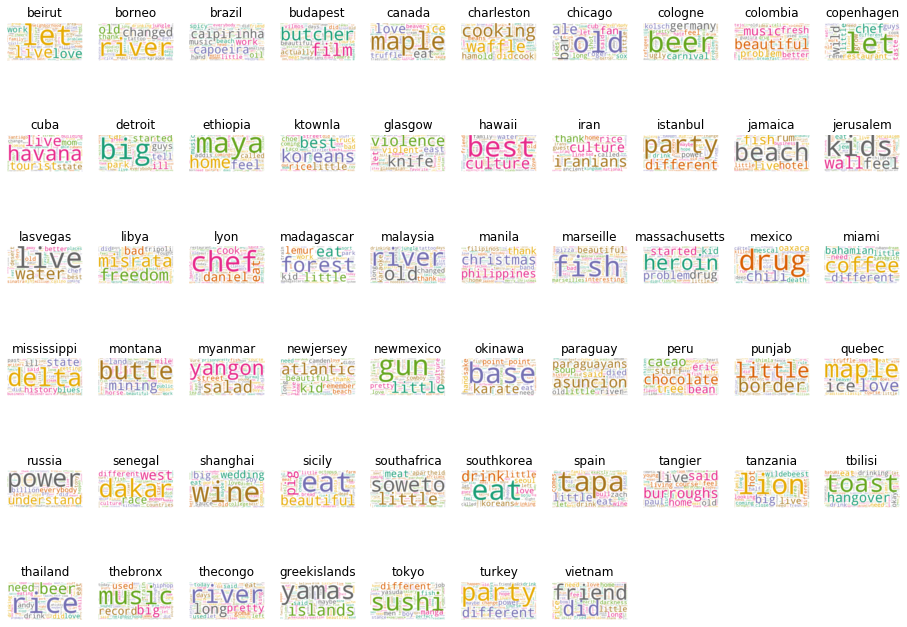

In [0]:
plt.rcParams['figure.figsize'] = [16, 12]

# Create subplots for each episode
for index, episode in enumerate(eda_df.columns):
    wc.generate(clean_df.transcript[episode])
    
    plt.subplot(6, 10, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(episode_columns[index])
    
plt.show()

In [0]:
eda_df.head()

episode,beirut,borneo,brazil,budapest,canada,charleston,chicago,cologne,colombia,copenhagen,cuba,detroit,ethiopia,ktownla,glasgow,hawaii,iran,istanbul,jamaica,jerusalem,lasvegas,libya,lyon,madagascar,malaysia,manila,marseille,massachusetts,mexico,miami,mississippi,montana,myanmar,newjersey,newmexico,okinawa,paraguay,peru,punjab,quebec,russia,senegal,shanghai,sicily,southafrica,southkorea,spain,tangier,tanzania,tbilisi,thailand,thebronx,thecongo,greekislands,tokyo,turkey,vietnam
aa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.022247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019741,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ababa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.055473,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018668,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abaha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Unique Words

In [0]:
# Find the number of unique words in each episode

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for episode in eda_df.columns:
    uniques = eda_df[episode].nonzero()[0].size
    unique_list.append(uniques)

# # Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(episode_columns, unique_list)), columns=['episode', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')

# data_unique_sort.to_pickle('/content/drive/My Drive/data_unique_sort.pickle')
# data_words.to_pickle("/content/drive/My Drive/data_words.pickle")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
data_words.to_csv('/content/drive/My Drive/unique_words.csv', index=None)

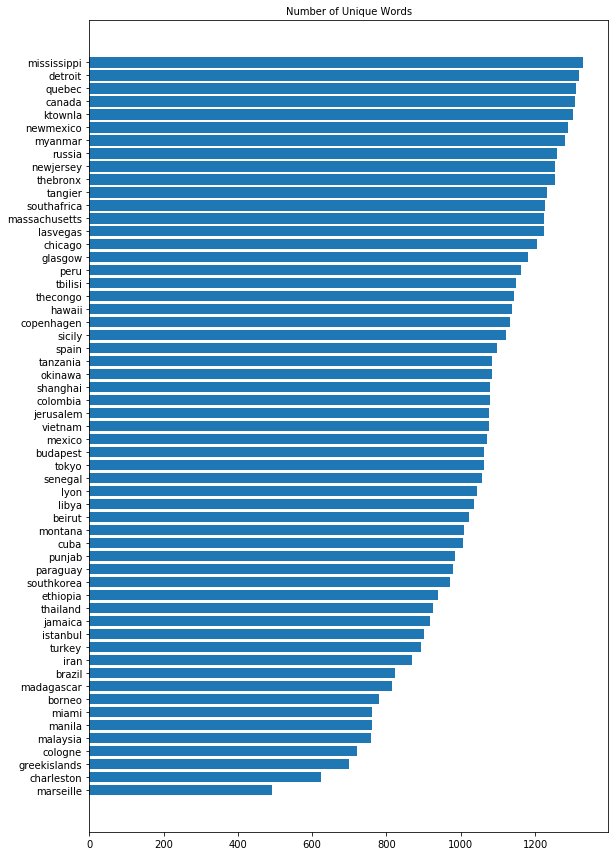

In [0]:
y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.episode)
plt.title('Number of Unique Words', fontsize=10)

plt.tight_layout()
plt.show()

## Sentiment Analysis

In [0]:
# Create quick lambda functions to find the polarity and subjectivity
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

clean_df['episode'] = clean_df.index
clean_df['polarity'] = clean_df['transcript'].apply(pol)
clean_df['subjectivity'] = clean_df['transcript'].apply(sub)
# clean_df.to_pickle('/content/drive/My Drive/clean_df.pickle')

Subjectivity averages around .50
This seems to make sense since Bourdain and his guests are primarily sharing their opinions of a given city/country


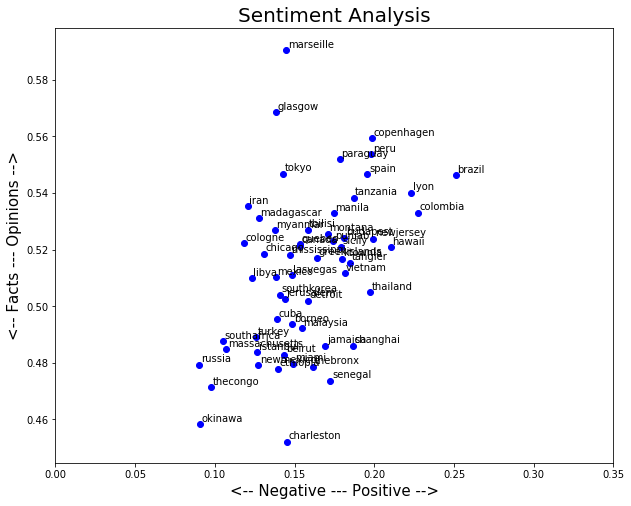

In [0]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, episode in enumerate(clean_df.index):
    x = clean_df.polarity.loc[episode]
    y = clean_df.subjectivity.loc[episode]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, clean_df['episode'][index], fontsize=10)
    plt.xlim(0, 0.35) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative --- Positive -->', fontsize=15)
plt.ylabel('<-- Facts --- Opinions -->', fontsize=15)

plt.show()

Plot a sentiment curve over the duration of each episode

# Topic Modeling (LDA, raw text)

In [0]:
from gensim import matutils, models
import scipy.sparse

In [0]:
topic_model_df = data_stop
topic_model_df.info

<bound method DataFrame.info of                      aa     aaron     ababa  ...       zui      zulu  zurkowski
episode                                      ...                               
beirut         0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
borneo         0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
brazil         0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
budapest       0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
canada         0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
charleston     0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
chicago        0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
cologne        0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
colombia       0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
copenhagen     0.000000  0.000000  0.000000  ...  0.000000  0.000000   0.000000
cuba    

In [0]:
tdm = topic_model_df.transpose()
tdm.info

<bound method DataFrame.info of episode    beirut  borneo  brazil  ...  tokyo  turkey   vietnam
aa            0.0     0.0     0.0  ...    0.0     0.0  0.000000
aaron         0.0     0.0     0.0  ...    0.0     0.0  0.000000
ababa         0.0     0.0     0.0  ...    0.0     0.0  0.000000
abad          0.0     0.0     0.0  ...    0.0     0.0  0.000000
abaha         0.0     0.0     0.0  ...    0.0     0.0  0.000000
...           ...     ...     ...  ...    ...     ...       ...
zsigmonds     0.0     0.0     0.0  ...    0.0     0.0  0.000000
zucchini      0.0     0.0     0.0  ...    0.0     0.0  0.000000
zui           0.0     0.0     0.0  ...    0.0     0.0  0.029745
zulu          0.0     0.0     0.0  ...    0.0     0.0  0.000000
zurkowski     0.0     0.0     0.0  ...    0.0     0.0  0.000000

[18133 rows x 57 columns]>

In [0]:
# Put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [0]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("/content/drive/My Drive/cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [0]:
# Run LDA
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=25)
lda.print_topics()

[(0,
  '0.000*"river" + 0.000*"yamas" + 0.000*"love" + 0.000*"old" + 0.000*"different" + 0.000*"little" + 0.000*"thank" + 0.000*"rice" + 0.000*"did" + 0.000*"fish"'),
 (1,
  '0.000*"little" + 0.000*"eat" + 0.000*"did" + 0.000*"love" + 0.000*"old" + 0.000*"fish" + 0.000*"different" + 0.000*"maybe" + 0.000*"big" + 0.000*"pretty"')]

In [0]:
# 4 topics
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=25)
lda.print_topics()

[(0,
  '0.000*"kuching" + 0.000*"karaoke" + 0.000*"jungle" + 0.000*"yamas" + 0.000*"marseilles" + 0.000*"upriver" + 0.000*"islands" + 0.000*"tattoo" + 0.000*"river" + 0.000*"elders"'),
 (1,
  '0.000*"turkeys" + 0.000*"armenians" + 0.000*"driver" + 0.000*"ruling" + 0.000*"serra" + 0.000*"voters" + 0.000*"party" + 0.000*"tear" + 0.000*"gassed" + 0.000*"istanbuls"'),
 (2,
  '0.000*"little" + 0.000*"eat" + 0.000*"did" + 0.000*"love" + 0.000*"old" + 0.000*"fish" + 0.000*"different" + 0.000*"maybe" + 0.000*"big" + 0.000*"pretty"'),
 (3,
  '0.000*"christmas" + 0.000*"cacao" + 0.000*"philippines" + 0.000*"little" + 0.000*"koreans" + 0.000*"butte" + 0.000*"eat" + 0.000*"kolsch" + 0.000*"iranians" + 0.000*"filipinos"')]

In [0]:
# 6 topics
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=6, passes=25)
lda.print_topics()

[(0,
  '0.000*"narco" + 0.000*"mescal" + 0.000*"oaxaca" + 0.000*"cartel" + 0.000*"tepito" + 0.000*"cartels" + 0.000*"santa" + 0.000*"del" + 0.000*"kamal" + 0.000*"sinaloa"'),
 (1,
  '0.000*"kolsch" + 0.000*"iranians" + 0.000*"carnival" + 0.000*"clowns" + 0.000*"prost" + 0.000*"refugees" + 0.000*"germany" + 0.000*"goma" + 0.000*"mimes" + 0.000*"germans"'),
 (2,
  '0.000*"turkeys" + 0.000*"armenians" + 0.000*"cacao" + 0.000*"driver" + 0.000*"chocolate" + 0.000*"voters" + 0.000*"serra" + 0.000*"tapas" + 0.000*"lions" + 0.000*"istanbuls"'),
 (3,
  '0.001*"little" + 0.000*"did" + 0.000*"eat" + 0.000*"love" + 0.000*"old" + 0.000*"fish" + 0.000*"different" + 0.000*"pretty" + 0.000*"maybe" + 0.000*"big"'),
 (4,
  '0.000*"maple" + 0.000*"fred" + 0.000*"beaver" + 0.000*"truffle" + 0.000*"hockey" + 0.000*"icy" + 0.000*"syrup" + 0.000*"christmas" + 0.000*"dave" + 0.000*"shack"'),
 (5,
  '0.000*"kuching" + 0.000*"karaoke" + 0.000*"jungle" + 0.000*"tattoo" + 0.000*"elders" + 0.000*"teow" + 0.000*"kw

In [0]:
# 12 topics
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=12, passes=25)
lda.print_topics()

[(0,
  '0.000*"marseilles" + 0.000*"seoul" + 0.000*"koreans" + 0.000*"soju" + 0.000*"retire" + 0.000*"bouillabaisse" + 0.000*"dynamite" + 0.000*"gamers" + 0.000*"noh" + 0.000*"amazons"'),
 (1,
  '0.000*"tapas" + 0.000*"koreans" + 0.000*"camden" + 0.000*"zach" + 0.000*"roy" + 0.000*"tapa" + 0.000*"sizzler" + 0.000*"choe" + 0.000*"koreatown" + 0.000*"kimchi"'),
 (2,
  '0.000*"lions" + 0.000*"lion" + 0.000*"shimla" + 0.000*"amritsar" + 0.000*"hippo" + 0.000*"hyenas" + 0.000*"wildebeests" + 0.000*"serengeti" + 0.000*"tanzania" + 0.000*"mutton"'),
 (3,
  '0.001*"little" + 0.001*"eat" + 0.001*"did" + 0.001*"love" + 0.001*"old" + 0.001*"fish" + 0.001*"different" + 0.001*"maybe" + 0.001*"big" + 0.001*"pretty"'),
 (4,
  '0.000*"kolsch" + 0.000*"paraguayans" + 0.000*"asuncion" + 0.000*"hallelujah" + 0.000*"blackwell" + 0.000*"bordeaux" + 0.000*"sinatra" + 0.000*"rum" + 0.000*"germans" + 0.000*"antonio"'),
 (5,
  '0.000*"goma" + 0.000*"paul" + 0.000*"bladder" + 0.000*"rebel" + 0.000*"weddings" + 

# Topic Modeling (LDA, nouns, Lemmed)

In [0]:
# Pull out nouns from a string of text
import nltk
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
# clean_df = clean_df.drop(["episode_num"], axis=1, errors="ignore")

In [0]:
# Apply the nouns function to the transcripts (LEMMED) to filter only on nouns
data_nouns = pd.DataFrame(clean_df.lemmed.apply(nouns))

In [0]:
data_nouns.head()

,lemmed
episode,
beirut,place everything world ill glorious maddening city beirut mediterranean sea ground wheel metal t...
borneo,i river i kind fist heart kindi year episode series lifeyet longhouse jungle i time i wa point l...
brazil,bahia heart heart brazil come sound drum city people capital brazil wellspring everything spicy ...
budapest,i deathbut tank camera wa shot soldierat time didnt i camera time history something something th...
canada,breed province quebec winter winter kind person river icy street normi partisanship front i mont...


In [0]:
# Noun-only DTM
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = TfidfVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.lemmed)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index

In [0]:
data_dtmn

,aa,aaron,ababa,abad,abaha,abalone,abandon,abdelileh,abdoulaye,abduction,abed,abide,abides,abigail,ability,aboard,abouti,aboutim,aboveboard,abru,absalom,absarika,absolute,absorption,absurdity,abu,abundance,abuse,abusive,abusrour,academy,acaraje,accent,access,accident,accolade,accommodation,accompaniment,accomplishment,account,...,yva,zach,zachs,zack,zagat,zaitoun,zamboni,zamir,zaneb,zanzibari,zanzibaris,zapotec,zarni,zayas,zeal,zealand,zeb,zebeck,zebra,zebu,zero,zeus,zhou,zhu,zia,zimmer,zing,zionist,ziran,zocalo,zombie,zone,zoneits,zoo,zooamichai,zsigmond,zucchini,zui,zulu,zurkowski
episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
beirut,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048056,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
borneo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
brazil,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.045898,0.000000,0.000000,0.000000,0.000000,0.000000,0.041637,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
budapest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.034247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034247,0.000000,0.000000,0.000000,0.000000
canada,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,

In [0]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [0]:
# 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.000*"family" + 0.000*"course" + 0.000*"music" + 0.000*"home" + 0.000*"culture" + 0.000*"restaurant" + 0.000*"today" + 0.000*"chef" + 0.000*"beer" + 0.000*"party"'),
 (1,
  '0.000*"family" + 0.000*"course" + 0.000*"home" + 0.000*"park" + 0.000*"waffle" + 0.000*"restaurant" + 0.000*"chef" + 0.000*"river" + 0.000*"party" + 0.000*"beer"')]

In [0]:
# 3 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.000*"chef" + 0.000*"bouillabaisse" + 0.000*"sushi" + 0.000*"crime" + 0.000*"butte" + 0.000*"hook" + 0.000*"pizza" + 0.000*"nightmare" + 0.000*"truck" + 0.000*"restaurant"'),
 (1,
  '0.001*"family" + 0.000*"course" + 0.000*"music" + 0.000*"home" + 0.000*"culture" + 0.000*"restaurant" + 0.000*"today" + 0.000*"beer" + 0.000*"chef" + 0.000*"party"'),
 (2,
  '0.000*"lion" + 0.000*"capoeira" + 0.000*"music" + 0.000*"party" + 0.000*"water" + 0.000*"caipirinha" + 0.000*"family" + 0.000*"oil" + 0.000*"today" + 0.000*"cup"')]

In [0]:
# 12 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=12, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.001*"delta" + 0.001*"tapa" + 0.000*"rum" + 0.000*"zach" + 0.000*"blackwell" + 0.000*"jew" + 0.000*"faulkner" + 0.000*"blue" + 0.000*"fence" + 0.000*"godfather"'),
 (1,
  '0.001*"lion" + 0.000*"casino" + 0.000*"yangon" + 0.000*"bouillabaisse" + 0.000*"saffron" + 0.000*"hyena" + 0.000*"tea" + 0.000*"axis" + 0.000*"sanction" + 0.000*"camden"'),
 (2,
  '0.001*"butte" + 0.001*"mining" + 0.000*"andy" + 0.000*"hen" + 0.000*"stream" + 0.000*"olympics" + 0.000*"pheasant" + 0.000*"prik" + 0.000*"borgnine" + 0.000*"access"'),
 (3,
  '0.001*"christmas" + 0.001*"maya" + 0.001*"butcher" + 0.000*"gypsy" + 0.000*"vilmos" + 0.000*"merry" + 0.000*"adobo" + 0.000*"addis" + 0.000*"aurora" + 0.000*"tank"'),
 (4,
  '0.001*"asuncion" + 0.000*"misrata" + 0.000*"rene" + 0.000*"bordeaux" + 0.000*"benghazi" + 0.000*"firework" + 0.000*"dictator" + 0.000*"chaco" + 0.000*"tripoli" + 0.000*"witch"'),
 (5,
  '0.002*"family" + 0.001*"course" + 0.001*"music" + 0.001*"home" + 0.001*"restaurant" + 0.001*"cultur

# Topic Modeling (LDA, nouns and adjectives, Lemmed)

In [0]:
# Pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [0]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(clean_df.lemmed.apply(nouns_adj))
data_nouns_adj

,lemmed
episode,
beirut,place everything great world ill glorious magical maddening magnificent city beirut backthe medi...
borneo,i river i sick bad kind fist heart kindi long year previous episode previous series previous lif...
brazil,bahia heart heart brazil magic come sound drum salvador bahia city people first capital brazil w...
budapest,i deathbut russian tank camera wa shot russian soldierat time i didnt i alive camera important t...
canada,special breed province quebec cold winter winter long special kind person frozen river icy stree...
charleston,south monolith pocket weirdness awesomeness time important thing food lot guyswhat beer weve stu...
chicago,somebody youre im chicago nobody response oh chicago hey likely itll wow chicago oh chicago they...
cologne,ground rule kolsch itll nothing wa dont u people cologne city proud statement people nice tolera...
colombia,good place experience fantasy reality air explosive food street random stranger bring delicious ...


In [0]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
cvna = TfidfVectorizer(stop_words=stop_words, max_df=.90)
data_cvna = cvna.fit_transform(data_nouns_adj.lemmed)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,aa,aaron,ababa,abad,abaha,abalone,abandon,abandoned,abdelileh,abdoulaye,abduction,abed,abeid,abide,abides,abigail,ability,able,aboard,abouti,aboutim,aboveboard,abrahamthe,abru,abrupt,absalom,absarika,absolute,absolutefor,absorbed,absorbent,absorption,abstract,absurd,absurdity,abu,abundance,abundant,abuse,abusive,...,zachs,zack,zagat,zaitoun,zamboni,zamir,zaneb,zanzibari,zanzibaris,zapotec,zapotecan,zarni,zayas,zeal,zealand,zeb,zebeck,zebra,zebu,zero,zeus,zhejiang,zhou,zhu,zia,zimmer,zing,zionist,ziran,zocalo,zombie,zone,zoneits,zoo,zooamichai,zsigmond,zucchini,zui,zulu,zurkowski
episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
beirut,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.030316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
borneo,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
brazil,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.014874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
budapest,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.022971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.030231,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030231,0.000000,0.000000,0.000000,0.000000
canada,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.023797,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0

In [0]:
data_dtmna

,aa,aaron,ababa,abad,abaha,abalone,abandon,abandoned,abdelileh,abdoulaye,abduction,abed,abeid,abide,abides,abigail,ability,able,aboard,abouti,aboutim,aboveboard,abrahamthe,abru,abrupt,absalom,absarika,absolute,absolutefor,absorbed,absorbent,absorption,abstract,absurd,absurdity,abu,abundance,abundant,abuse,abusive,...,zachs,zack,zagat,zaitoun,zamboni,zamir,zaneb,zanzibari,zanzibaris,zapotec,zapotecan,zarni,zayas,zeal,zealand,zeb,zebeck,zebra,zebu,zero,zeus,zhejiang,zhou,zhu,zia,zimmer,zing,zionist,ziran,zocalo,zombie,zone,zoneits,zoo,zooamichai,zsigmond,zucchini,zui,zulu,zurkowski
episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
beirut,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.030316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039897,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
borneo,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
brazil,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.014874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
budapest,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.022971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.030231,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030231,0.000000,0.000000,0.000000,0.000000
canada,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.023797,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0

In [0]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [0]:
# 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.000*"maple" + 0.000*"christmas" + 0.000*"chef" + 0.000*"truffle" + 0.000*"course" + 0.000*"party" + 0.000*"beer" + 0.000*"fish" + 0.000*"beautiful" + 0.000*"beach"'),
 (1,
  '0.000*"fish" + 0.000*"course" + 0.000*"beautiful" + 0.000*"music" + 0.000*"restaurant" + 0.000*"culture" + 0.000*"chef" + 0.000*"today" + 0.000*"party" + 0.000*"beer"')]

In [0]:
# 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.000*"course" + 0.000*"beach" + 0.000*"fish" + 0.000*"beautiful" + 0.000*"party" + 0.000*"beer" + 0.000*"friend" + 0.000*"rice" + 0.000*"culture" + 0.000*"music"'),
 (1,
  '0.000*"fish" + 0.000*"chef" + 0.000*"today" + 0.000*"stuff" + 0.000*"meat" + 0.000*"restaurant" + 0.000*"street" + 0.000*"music" + 0.000*"chicken" + 0.000*"woman"'),
 (2,
  '0.000*"waffle" + 0.000*"christmas" + 0.000*"merry" + 0.000*"bahamian" + 0.000*"adobo" + 0.000*"cooking" + 0.000*"aurora" + 0.000*"cubano" + 0.000*"florida" + 0.000*"grit"')]

In [0]:
# 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.000*"cartel" + 0.000*"dakar" + 0.000*"lion" + 0.000*"race" + 0.000*"mescal" + 0.000*"yangon" + 0.000*"drug" + 0.000*"car" + 0.000*"woman" + 0.000*"beer"'),
 (1,
  '0.000*"waffle" + 0.000*"bouillabaisse" + 0.000*"dynamite" + 0.000*"hook" + 0.000*"interesting" + 0.000*"mediterranean" + 0.000*"beach" + 0.000*"pizza" + 0.000*"brown" + 0.000*"butte"'),
 (2,
  '0.000*"fish" + 0.000*"course" + 0.000*"beautiful" + 0.000*"music" + 0.000*"restaurant" + 0.000*"culture" + 0.000*"today" + 0.000*"chef" + 0.000*"party" + 0.000*"beer"'),
 (3,
  '0.000*"maple" + 0.000*"hockey" + 0.000*"truffle" + 0.000*"tapa" + 0.000*"cabin" + 0.000*"christmas" + 0.000*"foie" + 0.000*"chocolate" + 0.000*"icy" + 0.000*"fred"')]

In [0]:
# 5 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=5, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.000*"tattoo" + 0.000*"karaoke" + 0.000*"chow" + 0.000*"jungle" + 0.000*"skull" + 0.000*"harvest" + 0.000*"eddie" + 0.000*"kuching" + 0.000*"malaysian" + 0.000*"tuak"'),
 (1,
  '0.000*"christmas" + 0.000*"merry" + 0.000*"cacao" + 0.000*"adobo" + 0.000*"maya" + 0.000*"aurora" + 0.000*"chocolate" + 0.000*"addis" + 0.000*"delta" + 0.000*"goma"'),
 (2,
  '0.000*"wine" + 0.000*"fish" + 0.000*"carnival" + 0.000*"cartel" + 0.000*"olive" + 0.000*"forest" + 0.000*"bahamian" + 0.000*"parent" + 0.000*"rene" + 0.000*"bread"'),
 (3,
  '0.000*"maple" + 0.000*"truffle" + 0.000*"lion" + 0.000*"tapa" + 0.000*"sushi" + 0.000*"butte" + 0.000*"chef" + 0.000*"heroin" + 0.000*"foie" + 0.000*"wine"'),
 (4,
  '0.000*"fish" + 0.000*"party" + 0.000*"music" + 0.000*"beautiful" + 0.000*"course" + 0.000*"rice" + 0.000*"woman" + 0.000*"culture" + 0.000*"restaurant" + 0.000*"friend"')]

In [0]:
# 6 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=6, id2word=id2wordna, passes=3)
ldana.print_topics()

[(0,
  '0.000*"rice" + 0.000*"freedom" + 0.000*"sushi" + 0.000*"fish" + 0.000*"power" + 0.000*"course" + 0.000*"woman" + 0.000*"night" + 0.000*"soup" + 0.000*"tank"'),
 (1,
  '0.000*"cartel" + 0.000*"asuncion" + 0.000*"mescal" + 0.000*"drug" + 0.000*"hiphop" + 0.000*"bordeaux" + 0.000*"narco" + 0.000*"record" + 0.000*"oaxaca" + 0.000*"dictator"'),
 (2,
  '0.000*"roy" + 0.000*"drug" + 0.000*"tomas" + 0.000*"tejo" + 0.000*"choe" + 0.000*"wayuu" + 0.000*"cali" + 0.000*"medellin" + 0.000*"fresh" + 0.000*"koreatown"'),
 (3,
  '0.000*"maple" + 0.000*"chef" + 0.000*"wine" + 0.000*"restaurant" + 0.000*"kid" + 0.000*"bad" + 0.000*"beer" + 0.000*"point" + 0.000*"problem" + 0.000*"course"'),
 (4,
  '0.000*"lion" + 0.000*"cacao" + 0.000*"waffle" + 0.000*"chocolate" + 0.000*"forest" + 0.000*"fish" + 0.000*"meat" + 0.000*"oil" + 0.000*"wild" + 0.000*"park"'),
 (5,
  '0.000*"beach" + 0.000*"butte" + 0.000*"maya" + 0.000*"rum" + 0.000*"tourist" + 0.000*"access" + 0.000*"water" + 0.000*"soweto" + 0.000

In [0]:
# 15 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=15, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.001*"maya" + 0.000*"bahamian" + 0.000*"addis" + 0.000*"florida" + 0.000*"cubano" + 0.000*"funk" + 0.000*"godfather" + 0.000*"sardine" + 0.000*"shrimp" + 0.000*"mafia"'),
 (1,
  '0.000*"butcher" + 0.000*"gypsy" + 0.000*"misrata" + 0.000*"tank" + 0.000*"vilmos" + 0.000*"hiphop" + 0.000*"tripoli" + 0.000*"gadhafis" + 0.000*"benghazi" + 0.000*"borough"'),
 (2,
  '0.001*"cacao" + 0.001*"chocolate" + 0.001*"tattoo" + 0.001*"jungle" + 0.000*"karaoke" + 0.000*"river" + 0.000*"harvest" + 0.000*"skull" + 0.000*"cyclades" + 0.000*"eddie"'),
 (3,
  '0.001*"butte" + 0.001*"christmas" + 0.000*"mining" + 0.000*"merry" + 0.000*"stream" + 0.000*"adobo" + 0.000*"hen" + 0.000*"burroughs" + 0.000*"socco" + 0.000*"aurora"'),
 (4,
  '0.000*"carnival" + 0.000*"rene" + 0.000*"kolsch" + 0.000*"roy" + 0.000*"david" + 0.000*"kway" + 0.000*"teow" + 0.000*"choe" + 0.000*"prost" + 0.000*"taco"'),
 (5,
  '0.001*"atlantic" + 0.000*"gun" + 0.000*"asuncion" + 0.000*"camden" + 0.000*"bordeaux" + 0.000*"casino"

In [0]:
# # Topics <> Episode
# corpus_transformed = ldana[corpusna]
# list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))

# Topic Modeling (LSA/SVD)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
# # Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
# cvna = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words, max_df=.80)
# data_cvna = cvna.fit_transform(data_nouns_adj.transcript)
# data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
# data_dtmna.index = data_nouns_adj.index
# data_dtmna

In [0]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
# cvna_lsa = CountVectorizer(stop_words=stop_words, max_df=.90)
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
cvna_lsa = TfidfVectorizer(min_df=.30)
data_cvna_lsa = cvna_lsa.fit_transform(data_nouns_adj.lemmed)
data_dtmna_lsa = pd.DataFrame(data_cvna_lsa.toarray(), columns=cvna_lsa.get_feature_names())
data_dtmna_lsa.index = data_nouns_adj.index
# data_dtmna_lsa.head()

In [0]:
len(stop_words)

566

In [0]:
data_dtmna_lsa

,able,age,air,alive,amazing,america,american,amount,ancient,animal,answer,anybody,anyone,anything,area,army,art,artist,attention,awesome,baby,back,bad,band,bar,base,beach,bean,beautiful,beef,beer,beginning,best,better,big,bigger,biggest,bit,black,blood,...,wa,walk,wall,war,warm,water,way,week,weird,welcome,well,west,weve,whats,white,whole,wife,wild,window,wine,woman,wonderful,wood,word,work,worker,world,worse,wow,writer,wrong,yeah,year,yes,york,youd,youll,young,youre,youve
episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
beirut,0.038404,0.000000,0.000000,0.063935,0.000000,0.000000,0.014770,0.021784,0.000000,0.020858,0.000000,0.021784,0.020000,0.014255,0.103387,0.146926,0.000000,0.048975,0.000000,0.031745,0.000000,0.000000,0.026122,0.024488,0.034184,0.000000,0.038404,0.000000,0.038509,0.018455,0.016466,0.000000,0.049598,0.055051,0.024799,0.000000,0.022791,0.013290,0.000000,0.020858,...,0.094191,0.000000,0.000000,0.184523,0.000000,0.015587,0.104153,0.015873,0.000000,0.017753,0.036198,0.020858,0.023329,0.044309,0.000000,0.012616,0.020000,0.021312,0.000000,0.020421,0.000000,0.000000,0.024488,0.017418,0.039183,0.000000,0.150444,0.000000,0.013061,0.000000,0.033550,0.340004,0.141286,0.105965,0.000000,0.022277,0.022791,0.029019,0.060936,0.015873
borneo,0.000000,0.048701,0.000000,0.029231,0.000000,0.000000,0.000000,0.059759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033587,0.000000,0.000000,0.000000,0.000000,0.125042,0.000000,0.035829,0.000000,0.000000,0.032773,0.026337,0.000000,0.000000,0.025313,0.067755,0.000000,0.017007,0.018877,0.017007,0.031999,0.000000,0.000000,0.067755,0.028609,...,0.064597,0.000000,0.000000,0.000000,0.000000,0.000000,0.111112,0.000000,0.058463,0.024351,0.000000,0.000000,0.000000,0.000000,0.021771,0.034608,0.000000,0.000000,0.000000,0.028010,0.023890,0.000000,0.000000,0.047781,0.035829,0.000000,0.047619,0.000000,0.017915,0.000000,0.023008,0.329190,0.242237,0.129193,0.000000,0.000000,0.000000,0.019901,0.100297,0.000000
brazil,0.021793,0.000000,0.000000,0.000000,0.044478,0.000000,0.016763,0.024724,0.000000,0.023673,0.000000,0.024724,0.000000,0.048538,0.016763,0.000000,0.090799,0.111171,0.000000,0.000000,0.000000,0.000000,0.014824,0.000000,0.000000,0.000000,0.152554,0.000000,0.058275,0.000000,0.056066,0.092709,0.028146,0.015620,0.056293,0.000000,0.000000,0.015084,0.018689,0.000000,...,0.040089,0.000000,0.000000,0.000000,0.027793,0.106143,0.065673,0.036030,0.000000,0.020150,0.000000,0.000000,0.000000,0.000000,0.000000,0.014319,0.000000,0.000000,0.000000,0.000000,0.118613,0.025867,0.027793,0.000000,0.044472,0.000000,0.105077,0.000000,0.014824,0.027793,0.019039,0.249696,0.053452,0.066815,0.000000,0.000000,0.025867,0.000000,0.096825,0.000000
budapest,0.034380,0.031786,0.019943,0.019079,0.017541,0.000000,0.000000,0.019502,0.019502,0.000000,0.064172,0.019502,0.017905,0.000000,0.000000,0.000000,0.017905,0.087688,0.000000,0.028419,0.020403,0.000000,0.046770,0.021922,0.030602,0.000000,0.000000,0.000000,0.137896,0.016521,0.000000,0.000000,0.055502,0.000000,0.033301,0.000000,0.020403,0.000000,0.000000,0.112034,...,0.221345,0.000000,0.021922,0.105120,0.000000,0.013954,0.082880,0.028419,0.000000,0.000000,0.000000,0.018672,0.020885,0.000000,0.000000,0.056470,0.053714,0.000000,0.021391,0.018281,0.000000,0.000000,0.000000,0.000000,0.058463,0.000000,0.062160,0.000000,0.023385,0.087688,0.000000,0.232760,0.084322,0.000000,0.016850,0.000000,0.000000,0.025978,0.065462,0.014209
canada,0.000000,0.049391,0.000000,0.019764,0.000000,0.049391,0.013697,0.020202,0.000000,0.019343,0.000000,0.040404,0.000000,0.013220,0.013697,0.000000,0.129832,0.000000,0.000000,0.044159,0.000000,0.018547,0.036337,0.000000,0.015850,0.000000,0.017807,0.037875,0.011904,0.085572,0.015270,0.018938,0.011499,0.038289,0.034497,0.000000,0.000000,0.036974,0.045810,0.077371,...,0.043675,0.000000,0.000000,0.000000,0.000000,0.014455,0.118052,0.014720,0.000000,0.000000,0.016784,0.000000,0.021635,0.013697,0.058878,0

In [0]:
lsa = TruncatedSVD(8)
doc_topic = lsa.fit_transform(data_cvna_lsa)
lsa.explained_variance_ratio_

array([0.0043824 , 0.05202256, 0.04592836, 0.04123561, 0.03438569,
       0.03410318, 0.03334851, 0.03158721])

In [0]:
topic_word = pd.DataFrame(lsa.components_.round(3), columns = cvna_lsa.get_feature_names())
topic_word

,able,age,air,alive,amazing,ancient,animal,answer,anybody,area,army,art,artist,attention,awesome,baby,bad,band,bar,base,beach,bean,beautiful,beef,beer,beginning,best,better,big,bigger,biggest,bit,blood,boat,body,bone,book,border,bowl,boy,...,tourist,tradition,traditional,travel,tree,trip,true,type,typical,unique,united,variety,vegetable,version,view,walk,wall,warm,water,week,weird,welcome,west,weve,wife,wild,window,wine,woman,wonderful,wood,word,work,worker,worse,wrong,youd,youll,young,youve
0,0.051,0.046,0.031,0.031,0.032,0.033,0.039,0.028,0.032,0.076,0.032,0.056,0.043,0.024,0.049,0.044,0.087,0.047,0.069,0.040,0.074,0.049,0.097,0.055,0.086,0.035,0.090,0.068,0.115,0.025,0.028,0.067,0.052,0.039,0.032,0.030,0.039,0.040,0.032,0.052,...,0.042,0.066,0.069,0.023,0.039,0.041,0.043,0.036,0.029,0.021,0.023,0.022,0.038,0.031,0.034,0.023,0.035,0.027,0.079,0.051,0.032,0.037,0.057,0.029,0.035,0.045,0.029,0.078,0.079,0.030,0.027,0.049,0.078,0.031,0.024,0.050,0.035,0.031,0.072,0.051
1,-0.081,0.022,0.008,0.008,-0.000,-0.019,0.039,-0.019,0.039,-0.071,-0.072,0.065,-0.035,0.008,0.008,0.002,-0.035,-0.058,-0.019,-0.054,-0.098,0.083,0.013,0.087,0.028,-0.004,0.005,-0.020,-0.007,-0.020,-0.013,0.066,0.084,0.006,-0.013,0.026,0.007,-0.038,0.031,0.021,...,-0.076,0.092,-0.023,0.015,0.115,0.015,-0.012,-0.023,-0.033,-0.030,-0.035,0.008,0.009,-0.013,-0.023,0.013,-0.029,0.003,0.023,-0.019,-0.033,-0.020,-0.113,0.037,0.020,0.115,0.011,0.223,-0.080,0.049,0.047,-0.016,-0.016,-0.010,-0.031,-0.020,-0.029,-0.009,-0.019,-0.016
2,-0.040,0.027,-0.018,0.039,-0.007,0.012,-0.000,-0.036,-0.041,-0.070,0.047,-0.049,-0.035,0.025,-0.013,0.167,-0.014,-0.066,-0.009,0.115,-0.116,-0.000,-0.096,0.039,0.162,-0.034,-0.045,-0.033,-0.025,0.011,-0.005,-0.052,0.085,-0.033,0.032,-0.004,-0.008,-0.018,0.091,0.025,...,-0.012,0.054,0.013,-0.028,-0.001,0.066,-0.029,0.071,-0.034,0.011,-0.008,0.004,-0.037,0.012,-0.032,-0.000,-0.035,-0.019,-0.040,-0.031,0.068,0.047,0.012,0.003,-0.022,-0.030,-0.012,-0.018,0.031,-0.013,-0.035,0.062,0.003,-0.017,-0.019,-0.016,-0.031,0.004,-0.021,-0.015
3,-0.025,-0.010,-0.004,-0.015,0.002,0.051,-0.001,-0.032,-0.009,-0.016,0.006,0.026,-0.017,-0.024,0.018,-0.060,0.022,-0.021,-0.086,0.045,-0.354,0.060,-0.111,0.058,-0.192,-0.024,-0.041,-0.017,-0.073,0.003,-0.013,0.012,-0.030,-0.073,-0.017,-0.020,0.024,0.095,-0.016,-0.040,...,-0.059,0.028,0.056,-0.003,0.054,-0.006,-0.010,-0.005,0.013,0.023,-0.044,0.025,0.001,-0.000,-0.028,-0.005,0.003,-0.047,-0.113,0.008,-0.022,0.009,0.093,0.006,0.002,0.041,0.008,0.073,-0.001,-0.003,0.012,0.032,0.035,-0.009,-0.007,0.068,-0.032,-0.042,0.056,-0.013
4,0.016,0.001,0.047,-0.005,0.027,0.053,0.003,0.020,0.012,0.020,-0.038,-0.024,0.005,0.004,-0.012,-0.073,0.042,-0.008,0.004,-0.016,-0.122,0.064,-0.081,-0.025,0.020,-0.001,0.066,0.024,-0.056,0.012,-0.021,0.002,-0.056,-0.096,0.073,0.007,0.055,0.040,0.019,0.077,...,-0.039,-0.027,-0.039,0.002,-0.002,0.001,0.015,0.029,-0.060,-0.005,-0.006,-0.020,0.112,0.001,0.033,0.023,0.107,0.003,-0.004,-0.078,-0.011,0.018,0.081,0.002,0.032,-0.030,0.062,-0.363,0.021,-0.010,-0.020,0.005,-0.019,-0.027,-0.019,-0.045,0.035,-0.003,0.019,0.058
5,-0.021,0.026,0.031,0.009,-0.031,0.009,-0.050,0.034,0.029,0.028,-0.042,-0.009,0.015,0.004,-0.019,0.037,0.053,-0.029,-0.100,-0.107,0.081,-0.009,0.089,0.022,-0.253,-0.044,-0.015,0.005,-0.056,0.018,0.042,0.009,-0.016,0.039,0.022,-0.004,0.010,-0.021,-0.037,-0.010,...,0.051,-0.037,-0.033,0.028,0.072,0.073,0.006,0.016,-0.003,0.001,-0.015,-0.019,-0.009,-0.022,0.018,-0.012,0.040,-0.035,0.069,-0.066,0.005,0.022,-0.096,0.024,0.009,-0.022,0.027,-0.065,-0.074,-0.004,0.031,0.014,0.072,0.011,-0.007,0.023,0.020,-0.049,-0.009,0.064
6,-0.059,-0.083,0.001,0.004,0.038,0.015,0.038,0.046,-0.048,0.020,0.019,-0.114,0.021,-0.018,-0.020,-0.002,0.004,-0.054,-0.019,0.044,0.191,0.064,0.145,-0.042,-0.077,0.000,-0.005,-0.043,-0.086,-0.040,-0.017,0.034,-0.062,0.062,-0.016,-0.018,-0.018,0.015,0.030,-0.061,...,0.036,-0.062,0.087,-0.037,0.107,0.035,0.001,-0.020,0.041,0.021,-0.017,0.035,0.089,-0.009,0.031,0.001,-0.036,

In [0]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [0]:
display_topics(lsa, cvna_lsa.get_feature_names(), 10)


Topic  0
little, old, different, family, big, fish, course, music, home, beautiful

Topic  1
chef, wine, sauce, shrimp, cook, tree, wild, classic, little, pork

Topic  2
river, rice, chili, baby, beer, party, pepper, hot, base, broth

Topic  3
party, power, restaurant, rule, modern, change, east, future, chef, egg

Topic  4
rice, green, chef, cooking, kid, film, vegetable, flavor, experience, wall

Topic  5
river, fish, long, film, group, land, mile, scene, beautiful, kid

Topic  6
fish, oil, beach, beautiful, market, different, sea, flavor, fresh, meat

Topic  7
beach, land, base, sea, area, point, kid, wine, tourist, force


In [0]:
Vt = pd.DataFrame(doc_topic.round(5), index=data_dtmna_lsa.index)
Vt

,0,1,2,3,4,5,6,7
episode,,,,,,,,
beirut,0.65541,-0.28806,-0.06100,0.00159,-0.09749,-0.13456,0.01641,0.02831
borneo,0.56937,-0.02781,0.71204,-0.06293,-0.04436,0.18043,-0.00710,0.00556
brazil,0.61384,-0.05159,-0.05932,-0.14353,-0.18118,-0.03541,0.27582,-0.15647
budapest,0.58458,-0.00894,0.06894,-0.08706,0.00504,0.20782,0.02866,-0.23827
canada,0.66634,0.47252,-0.12678,0.19454,-0.15031,0.11024,-0.28086,0.03162
charleston,0.53005,0.23232,0.01200,0.06208,0.34443,-0.16574,0.10248,-0.06922
chicago,0.65849,-0.13178,-0.05412,-0.18926,-0.01574,-0.01748,-0.12528,-0.12629
cologne,0.51109,-0.03383,0.08600,-0.18721,-0.05377,-0.27549,-0.23730,0.08799
colombia,0.63496,-0.03986,-0.06685,-0.20647,-0.14518,0.02331,0.20327,-0.14217


# Topic Modeling (NMF)

In [0]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

cvna_nmf = TfidfVectorizer(stop_words=stop_words, min_df=.35)
data_cvna_nmf = cvna_nmf.fit_transform(data_nouns_adj.lemmed)
data_dtmna_nmf = pd.DataFrame(data_cvna_nmf.toarray(), columns=cvna_nmf.get_feature_names())
data_dtmna_nmf.index = data_nouns_adj.index
# data_dtmna_nmf.head()

In [0]:
nmf_model = NMF(8)
doc_topic_nmf = nmf_model.fit_transform(data_cvna_nmf)

In [0]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3), columns = cvna_nmf.get_feature_names())

In [0]:
topic_word_nmf

,able,age,air,alive,amazing,ancient,animal,anybody,area,art,awesome,baby,bad,bar,beach,bean,beautiful,beef,beer,beginning,best,better,big,bigger,biggest,bit,blood,body,bone,book,boy,bread,breakfast,broth,brother,building,business,butter,capital,car,...,sweet,table,taste,tasty,thank,thousand,tiny,today,tomato,tomorrow,tonight,tony,tough,tradition,traditional,trip,true,type,typical,variety,version,view,water,week,weird,welcome,west,weve,wife,wild,wine,woman,wonderful,word,work,wrong,youd,youll,young,youve
0,0.189,0.065,0.081,0.069,0.000,0.085,0.114,0.085,0.238,0.067,0.039,0.020,0.172,0.040,0.000,0.039,0.089,0.016,0.041,0.032,0.173,0.125,0.216,0.076,0.043,0.048,0.063,0.051,0.039,0.043,0.089,0.053,0.000,0.005,0.061,0.057,0.091,0.017,0.008,0.167,...,0.015,0.022,0.044,0.042,0.080,0.110,0.024,0.187,0.060,0.012,0.019,0.070,0.023,0.049,0.079,0.031,0.036,0.039,0.043,0.004,0.006,0.086,0.114,0.042,0.023,0.025,0.055,0.028,0.030,0.000,0.000,0.070,0.069,0.098,0.081,0.000,0.143,0.045,0.170,0.093
1,0.000,0.021,0.061,0.012,0.063,0.043,0.022,0.043,0.021,0.055,0.037,0.000,0.074,0.028,0.000,0.169,0.078,0.071,0.039,0.031,0.129,0.064,0.011,0.000,0.002,0.108,0.000,0.046,0.033,0.066,0.056,0.074,0.000,0.040,0.000,0.000,0.045,0.129,0.038,0.125,...,0.028,0.056,0.086,0.042,0.048,0.021,0.031,0.061,0.017,0.000,0.042,0.011,0.019,0.071,0.059,0.038,0.048,0.016,0.000,0.027,0.018,0.030,0.102,0.000,0.000,0.033,0.005,0.038,0.050,0.138,0.000,0.000,0.025,0.018,0.062,0.038,0.010,0.010,0.050,0.068
2,0.002,0.070,0.000,0.065,0.010,0.010,0.011,0.000,0.000,0.000,0.000,0.211,0.086,0.034,0.054,0.003,0.019,0.051,0.244,0.000,0.016,0.016,0.027,0.024,0.000,0.000,0.112,0.059,0.017,0.000,0.060,0.000,0.121,0.162,0.055,0.043,0.027,0.000,0.108,0.015,...,0.023,0.052,0.010,0.011,0.152,0.000,0.001,0.000,0.003,0.029,0.029,0.044,0.000,0.117,0.045,0.050,0.000,0.100,0.000,0.014,0.028,0.001,0.016,0.003,0.099,0.058,0.011,0.000,0.008,0.000,0.001,0.075,0.016,0.096,0.051,0.010,0.000,0.014,0.042,0.011
3,0.053,0.000,0.000,0.004,0.039,0.052,0.000,0.000,0.067,0.007,0.043,0.000,0.078,0.039,0.000,0.037,0.024,0.029,0.000,0.018,0.018,0.036,0.017,0.014,0.007,0.022,0.000,0.014,0.000,0.033,0.000,0.023,0.036,0.014,0.000,0.209,0.107,0.008,0.020,0.036,...,0.015,0.023,0.000,0.050,0.049,0.023,0.057,0.077,0.030,0.046,0.013,0.037,0.017,0.023,0.109,0.004,0.029,0.032,0.056,0.046,0.037,0.014,0.000,0.065,0.034,0.047,0.171,0.000,0.012,0.011,0.000,0.108,0.000,0.062,0.089,0.120,0.000,0.005,0.094,0.020
4,0.016,0.063,0.000,0.039,0.000,0.000,0.080,0.046,0.025,0.136,0.058,0.055,0.049,0.050,0.000,0.024,0.091,0.114,0.084,0.021,0.037,0.028,0.157,0.017,0.010,0.085,0.143,0.000,0.039,0.009,0.033,0.170,0.013,0.000,0.023,0.000,0.000,0.037,0.000,0.003,...,0.086,0.115,0.031,0.000,0.038,0.014,0.041,0.065,0.082,0.000,0.017,0.032,0.082,0.151,0.062,0.008,0.005,0.000,0.047,0.038,0.019,0.000,0.012,0.102,0.016,0.000,0.000,0.036,0.035,0.092,0.477,0.039,0.074,0.046,0.050,0.053,0.000,0.022,0.079,0.000
5,0.000,0.017,0.032,0.012,0.012,0.048,0.025,0.006,0.062,0.000,0.073,0.019,0.028,0.004,0.000,0.035,0.083,0.092,0.000,0.000,0.035,0.014,0.108,0.030,0.117,0.086,0.075,0.012,0.016,0.054,0.036,0.001,0.000,0.011,0.059,0.091,0.011,0.006,0.049,0.031,...,0.002,0.019,0.027,0.000,0.026,0.067,0.005,0.152,0.000,0.099,0.026,0.076,0.033,0.000,0.065,0.178,0.053,0.024,0.016,0.000,0.016,0.025,0.097,0.024,0.008,0.080,0.012,0.105,0.030,0.008,0.023,0.055,0.000,0.026,0.109,0.044,0.040,0.017,0.000,0.084
6,0.027,0.000,0.024,0.020,0.009,0.000,0.007,0.040,0.136,0.000,0.000,0.037,0.097,0.042,0.724,0.000,0.303,0.000,0.058,0.029,0.036,0.031,0.021,0.000,0.001,0.060,0.000,0.000,0.005,0.000,0.000,0.000,0.093,0.064,0.031,0.020,0.133,0.000,0.035,0.049,...,0.025,0.000,0.017,0.050,0.101,0.000,0.013,0.075,0.040,0.015,0.034,0.054,0.000,0.022,0.058,0.013,0.006,0.000,0.071,0.021,0.003,0.060,0.145,0.016,0.033,0.000,0.000,0.000,0.016,0.015,0.014,0.057,0.016,0.000,0.044,0.053,0.000,0.009,0.017,0.022
7,0.070,0.077,0.000,0.000,0.078,0.000,0.000,0.000,0.000,0.088,0.071,0.033,0.023,0.228,0.0

In [0]:
display_topics(nmf_model, cvna_nmf.get_feature_names(), 10)


Topic  0
kid, family, culture, neighborhood, area, big, everybody, generation, able, today

Topic  1
chef, restaurant, flavor, green, little, cook, bean, cooking, old, meat

Topic  2
river, rice, beer, old, baby, chili, party, pepper, broth, hot

Topic  3
party, power, different, building, change, west, future, east, friend, space

Topic  4
wine, sauce, little, course, cheese, bread, glass, big, drinking, tradition

Topic  5
river, group, fish, soup, trip, chicken, today, course, meat, little

Topic  6
beach, beautiful, fish, little, sea, long, kid, hotel, problem, water

Topic  7
music, bar, culture, big, different, woman, beer, favorite, community, little


In [0]:
nmf_weights = pd.DataFrame(doc_topic_nmf.round(5),
             index=data_dtmna_lsa.index)
nmf_weights

,0,1,2,3,4,5,6,7
episode,,,,,,,,
beirut,0.25939,0.00000,0.00000,0.19412,0.04374,0.04859,0.06692,0.12139
borneo,0.00000,0.00000,0.82287,0.00326,0.00000,0.03004,0.00000,0.00000
brazil,0.00000,0.05263,0.04034,0.09958,0.06542,0.00000,0.32345,0.23531
budapest,0.00000,0.05895,0.12642,0.00000,0.06244,0.27742,0.06299,0.17670
canada,0.00000,0.26882,0.00000,0.00000,0.56031,0.00661,0.00000,0.00000
charleston,0.00349,0.48609,0.09469,0.00000,0.00000,0.00000,0.00000,0.08994
chicago,0.18243,0.00000,0.06508,0.00000,0.03903,0.01149,0.03062,0.37502
cologne,0.06485,0.00000,0.18928,0.00000,0.17437,0.00000,0.04912,0.15715
colombia,0.00000,0.13970,0.04102,0.00000,0.04769,0.03776,0.21500,0.31622


# Logistic Regression

In [0]:
model_df = nmf_weights

In [0]:
model_df['episode'] = model_df.index

In [0]:
cols = model_df.columns.to_list()
cols.insert(0, cols.pop(cols.index('episode')))
model_df = model_df.reindex(columns = cols)

In [0]:
model_df.head()

,episode,0,1,2,3,4,5,6,7
episode,,,,,,,,,
beirut,beirut,0.25939,0.00000,0.00000,0.19412,0.04374,0.04859,0.06692,0.12139
borneo,borneo,0.00000,0.00000,0.82287,0.00326,0.00000,0.03004,0.00000,0.00000
brazil,brazil,0.00000,0.05263,0.04034,0.09958,0.06542,0.00000,0.32345,0.23531
budapest,budapest,0.00000,0.05895,0.12642,0.00000,0.06244,0.27742,0.06299,0.17670
canada,canada,0.00000,0.26882,0.00000,0.00000,0.56031,0.00661,0.00000,0.00000


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
y = model_df.iloc[:,0]
X = model_df.iloc[:,1:]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state = 89)

In [0]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))

The score for logistic regression is
Training:  34.21%
Test set:   0.00%


In [0]:
# # Import ADASYN and create a new oversampled dataset

# ## Code goes here ##
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=89).fit_sample(X,y)

In [0]:
lr.fit(X_adasyn, y_adasyn)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_adasyn, y_adasyn)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))

The score for logistic regression is
Training:  29.82%
Test set:  31.58%


# Viz

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
# stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

tf_vectorizer = CountVectorizer(stop_words='english', min_df=.35)
tf_matrix = tf_vectorizer.fit_transform(data_nouns_adj.lemmed)
tf_words = tf_vectorizer.get_feature_names()

tf_matrix.shape

(57, 397)

In [0]:
# tf-idf (term frequency-inverse document frequency)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=.30)
tfidf_matrix = tfidf_vectorizer.fit_transform(data_nouns_adj.lemmed)
tfidf_words = tfidf_vectorizer.get_feature_names()

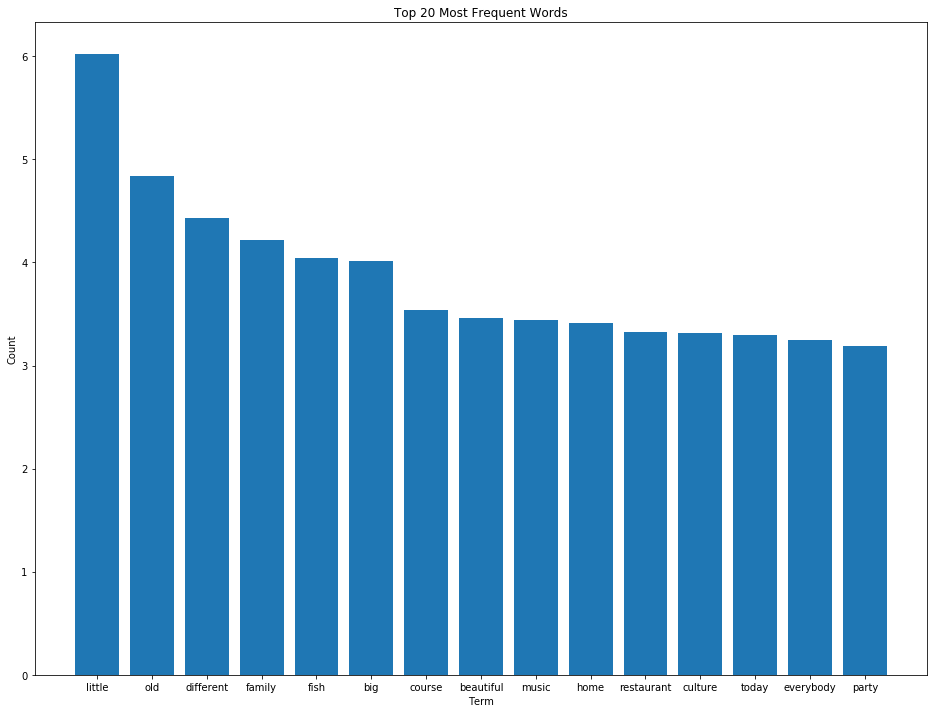

In [0]:
# get word frequencies from the bag of words and sort them by count in descending order
term_frequency = [(term, tfidf_matrix.sum(axis=0)[0, i]) for term, i in tfidf_vectorizer.vocabulary_.items()]
term_frequency = sorted(term_frequency, key = lambda x: x[1], reverse=True)
terms = [i[0] for i in term_frequency[:15]] # get top words
count = [i[1] for i in term_frequency[:15]] # get counts of top words

# plot the 20 most frequent words in a bar chart
fig, ax = plt.subplots(figsize=(16,12))
ax.bar(range(len(terms)), count)
ax.set_xticks(range(len(terms)))
ax.set_xticklabels(terms)
ax.set_title('Top 20 Most Frequent Words')
ax.set_xlabel('Term')
ax.set_ylabel('Count')
plt.show()

In [0]:
from sklearn.cluster import KMeans

k = 4 # number of clusters

# build and fit model, then store centroids
km = KMeans(k)
km_matrix = km.fit_transform(tfidf_matrix)
km_centroids = km.cluster_centers_.argsort()[:, ::-1]

# create a dictionary with the top three words for each cluster
top_words = {}
for i in range(4):
    top_words[i] = ""
    for c in km_centroids[i, :9]:
        if top_words[i] == "":
            top_words[i] = tfidf_words[c]
        else:
            top_words[i] = top_words[i] + ", " + tfidf_words[c]
    print('Cluster %s:' %i, top_words[i])

Cluster 0: river, rice, film, chili, old, beer, blood, chicken, course
Cluster 1: little, culture, different, family, music, big, kid, old, neighborhood
Cluster 2: little, wine, chef, old, big, fish, sauce, soup, family
Cluster 3: party, power, different, oil, old, base, meat, friend, restaurant


In [0]:
pca_df = nmf_weights

In [0]:
pca_df.head()

,0,1,2,3,4,5,6,7
0,0.16611,0.00000,0.00000,0.22550,0.00000,0.12281,0.09549,0.16858
1,0.00000,0.00000,0.83648,0.00000,0.00000,0.07428,0.00000,0.00000
2,0.00000,0.07169,0.00164,0.09939,0.03032,0.09558,0.30201,0.21905
3,0.01869,0.08325,0.27819,0.00000,0.11110,0.00000,0.03320,0.23896
4,0.00000,0.17699,0.00000,0.00000,0.73401,0.00000,0.00000,0.00000


In [0]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(pca_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca.components_

array([[-0.1926935 ,  0.17356759, -0.34395436, -0.1067516 ,  0.88027768,
        -0.08109973, -0.03114339, -0.14355181],
       [-0.01004007, -0.11963429, -0.55637795,  0.81435877, -0.1042449 ,
        -0.00176436,  0.00830637, -0.04371607]])

In [0]:
pca.transform(pca_df)

array([[-1.34036883e-01,  1.77028429e-01],
       [-3.34557402e-01, -4.63678643e-01],
       [-6.14655740e-02,  6.29047771e-02],
       [-6.31972273e-02, -1.84826772e-01],
       [ 6.36029977e-01, -9.58394286e-02],
       [ 2.12808730e-02, -5.55091403e-02],
       [-1.43938872e-01, -7.02041844e-02],
       [-7.26818156e-02, -1.85219815e-04],
       [-9.20753698e-02, -8.60112398e-02],
       [ 1.01556252e-01, -6.53321428e-02],
       [-1.30029956e-01,  1.45698644e-01],
       [ 1.36367891e-02, -4.49107756e-02],
       [-2.85227310e-02, -8.57210350e-04],
       [-6.04329261e-02, -3.14239935e-02],
       [ 3.30883274e-01,  2.17205082e-02],
       [-1.03855156e-01,  2.06289524e-02],
       [-1.19049480e-01,  1.23284945e-01],
       [-1.30551365e-01,  6.86352564e-01],
       [-6.37579254e-02,  7.96866833e-03],
       [-1.11823395e-01,  1.08707711e-01],
       [-4.51393267e-02, -7.09183437e-02],
       [-1.34104315e-01, -2.90951665e-03],
       [ 2.48639227e-01, -9.15237350e-02],
       [-7.

In [0]:
pca_df = pd.DataFrame(pca.transform(pca_df))

In [0]:
pca_df['episode'] = nmf_weights.index

In [0]:
cols = pca_df.columns.to_list()
cols.insert(0, cols.pop(cols.index('episode')))
pca_df = pca_df.reindex(columns = cols)

In [0]:
pca_df.to_csv('/content/drive/My Drive/pca_df.csv', index=None)

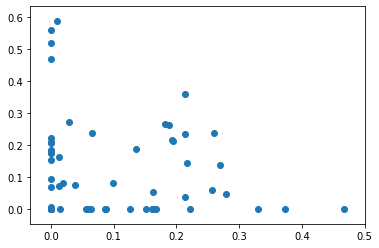

In [0]:
plt.scatter(pca_df[0], pca_df[1])

In [0]:
pca.components_

array([[-0.1926935 ,  0.17356759, -0.34395436, -0.1067516 ,  0.88027768,
        -0.08109973, -0.03114339, -0.14355181],
       [-0.01004007, -0.11963429, -0.55637795,  0.81435877, -0.1042449 ,
        -0.00176436,  0.00830637, -0.04371607]])

In [0]:
pca.explained_variance_

array([0.0367879 , 0.03328043])